In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
from scipy.optimize import curve_fit
import B00_codes.dataReader as dr
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import math
import json
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm

NO_MS_EQUALS_1 = 0
Q_FINAL = 1
THREE_PI_HALF_FINAL = 2
REF_MINUS_SIG  = 3

pi = np.pi

def running_average(arr):
    running_sum = 0
    running_avg = []

    for i, num in enumerate(arr):
        running_sum += num
        avg = running_sum / (i + 1)  # Calculate the running average
        running_avg.append(avg)

    return running_avg

def smooth(x, n=3):
    K = int((n-1)/2)
    smoothed_x = np.zeros(len(x))
    for i in range(K):
        smoothed_x[i] = x[i]
        smoothed_x[-i-1] = x[-i-1]
    for i in range(0, len(x)-(n-1)):
        for j in range(n):
            smoothed_x[i+K] += x[i+j]/n
    return smoothed_x

def smoothConvolution(x, n=5):
    K = int((n-1)/2)
    mask = np.ones(n)/n
    z = np.convolve(x,mask,'same')
    z[-K:] = x[-K:]
    return z

def average(y, n):
    # Initialize an empty list to store the averages
    averages = []

    # Iterate through the array in steps of 3
    for i in range(0, len(y), n):
        group = y[i:i + n]  # Get a group of three points
        average = np.mean(group)  # Calculate the average of the group
        averages.append(average)  # Add the average to the list

    # Convert the list of averages back to a NumPy array
    return np.array(averages)

def cov(a,b,axis=1):
    prod = a*b
    prod = np.nan_to_num(prod)
    prodavg = np.average(prod,axis=axis)
    aavg = np.average(a,axis=axis)
    bavg = np.average(b,axis=axis)
    sigma_a = np.std(a, axis=axis)
    sigma_b = np.std(b, axis=axis)
    # print(prodavg)
    # print(aavg)
    # print(bavg)
    # print(sigma_a)
    return (prodavg - aavg*bavg)/(sigma_a * sigma_b)

def thresholded(sig,thres):
    (row, col) = np.shape(sig)

    sigThd = np.zeros((row, col))
    for i in range(row):
        for j in range(col):
            if sig[i,j] > thres: sigThd[i,j] = 1
    return sigThd

def contrast_new(sigs,refs,sigavg,refavg):
    (row, col) = np.shape(sigs)
    contrast = np.zeros((row,col))
    diff = sigs-refs
    for i in range(row):
        contrast[i] = diff[i]/(sigavg[i]+refavg[i])
    return contrast

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

def subtractMeanFewReps(array,n):
    reshaped_array = array.reshape(-1, n)
    mean_per_group = np.mean(reshaped_array, axis=1)
    mean_repeated  = np.repeat(mean_per_group, n)
    result_array   = array - mean_repeated
    return result_array

def fourier(y, delta_t, f_factor=1):
    yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
    f = np.fft.fftfreq(len(y), delta_t)/f_factor  # insert spacing

    sorted_indices = np.argsort(f)       # Get the indices that would sort f
    f = f[sorted_indices]                # Sort f in ascending order
    yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

    return f,yfourier

def circular_shift(arr, shift_amount):
    n = len(arr)
    # Use modulo to handle circular shifting
    shifted_arr = np.concatenate((arr[-shift_amount % n:], arr[:-shift_amount % n]))
    return shifted_arr

def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    f = offset + amplitude * np.exp(
        -((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return f.ravel()



# Init

In [ ]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#013_CalibReadoutPhotonStat_02-13-07/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#154_CalibReadoutPhotonStat_06-36-03/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#200_CalibReadoutPhotonStat_12-15-04/CalibReadoutPhotonStatObject_sig_set.dat'

sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
    dataFilename, num_of_bins=1, plot_hist_every=5, binwidth=1)

In [ ]:
# Repeat measuring photon stats
days = np.linspace(31,31, 1)
dataArr = []; gArr = []; err_gArr = []; sigAvgs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-10-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'PhotonStat' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 294 and idx <= 816:
                datafile = mainFolder + dataFolder +'/CalibReadoutPhotonStatObject_sig_set.dat'
                current = 65

                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)
                sigAvg = np.average(sig,1)
                if sigAvgs is None: sigAvgs = sigAvg
                else: sigAvgs = np.vstack((sigAvgs, sigAvg))
                

In [ ]:
fig,ax = plt.subplots()
xplot = yplot/1e6    # yplot is already readout time in ns
# yplot = np.linspace(636.5,637.13,63)
yplot = np.arange(1, 1+0.1*523, 0.1)
Xplot, Yplot = np.meshgrid(xplot,yplot)
plot = ax.pcolormesh(Xplot, Yplot, sigAvgs, cmap='inferno')
ax.set_xlabel(r"Readout time (ms)")
ax.set_ylabel(r"Wavelength (nm)")
ax.set_title("Averaged signal (kc/s)")
fig.colorbar(plot, orientation='vertical')

In [ ]:
fig,ax = plt.subplots(figsize=(9,2))
time_idx = -1
ax.plot(yplot, sigAvgs[:,time_idx],  'o-', markersize=3, )
ax.set_ylabel(r"Averaged signal (kc/s). ")
ax.set_xlabel(r"Wavelength (nm)")
ax.set_title("Readout time = %.0f ms" % xplot[time_idx]);

# Find optical resonant

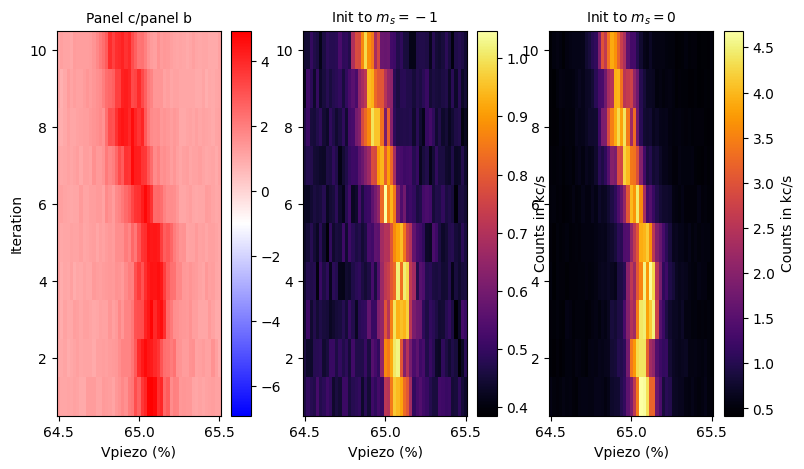

<Figure size 640x480 with 0 Axes>

In [275]:
# ODMR
days = np.linspace(28,28,1)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanRRFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 17 and idx <= 26):
                datafile = mainFolder + dataFolder +'/ScanRRFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = ref/sig
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap=cmap, norm=norm)
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('Panel c/panel b',fontsize=10)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('Vpiezo (%)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

# for i in range(3):
#     axs[i].set_xlim((55,60))
#     # axs[i].set_ylim((0,175))

plt.show()
plt.tight_layout()

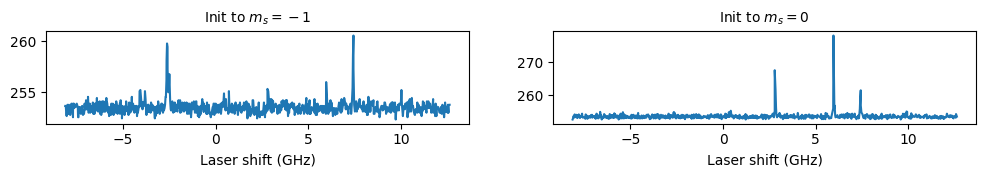

<Figure size 640x480 with 0 Axes>

In [485]:
# ODMR
days = np.linspace(29,29,1)
fig, axs = plt.subplots(1,2,figsize=(12,1.2))
# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1); separation = 18
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanRRFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            # if (idx >= 27 and idx <= 36):
            # if (idx >= 40 and idx <= 43):
            # if idx >= 136 and np.mod(idx,2)==0: # NV1
            # if idx >= 136 and np.mod(idx,2) == 1: # NV2
            # if idx >= 17 and idx <= 37:# and np.mod(idx,2) == 1: # NV1
            if idx == 14:
                dataArr = []
                if 'PumpFree' not in dataFolder:
                    datafile = mainFolder + dataFolder +'/ScanRRFreqObject_sig_set.dat'
                    x_s, sig, ref, wvl = dr.readDataNoPlotWM(datafile)
                else:
                    datafile = mainFolder + dataFolder +'/ScanRRFreqPumpFreeObject_sig_set.dat'
                    x_s, sig, ref, wvl = dr.readDataNoPlotWMJustRef(datafile)
                sig = np.array(sig); ref = np.array(ref); wvl = np.array(wvl)
                wvl=(wvl-470.468)*1e3

                sorted_indices = np.argsort(wvl)
                # Sort array1 in ascending order
                wvl = wvl[sorted_indices]; sig = sig[sorted_indices]; ref = ref[sorted_indices]
                contrast = sig-ref

                if idx <= 19 and np.mod(idx,2) == 0:
                    sig = sig*4; ref = ref*4
                if 'PumpFree' in dataFolder:
                    sig = sig*10; ref = ref*10
                # sig=ref-sig

                plot1 = axs[0].plot(wvl, sig+separation*idx, marker='o',markersize=0)
                # plot1 = axs[0].plot(x_s, sig+separation*idx)
                axs[0].set_xlabel('Laser shift (GHz)')
                axs[0].set_title('Init to $m_s = -1$',fontsize=10)
                
                plot2 = axs[1].plot(wvl, ref+separation*idx, marker='o',markersize=0)
                axs[1].set_xlabel('Laser shift (GHz)')
                axs[1].set_title('Init to $m_s = 0$',fontsize=10)
                
# for i in range(2):
#     axs[i].set_xlim((2,9))
    # axs[i].set_ylim((40,44.5))

plt.show()
plt.tight_layout()

In [484]:
ysig1 = sig; yref1 = ref; x1Plot = wvl

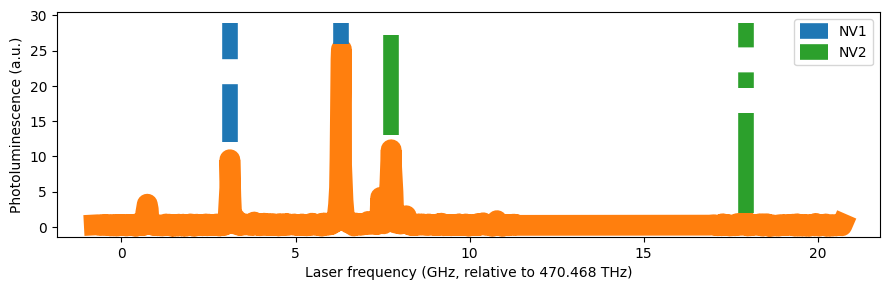

In [540]:
ysig = sig; yref = ref; x = wvl; ms=0; lw = 15; scale = 0.

fig, ax = plt.subplots(1,1, figsize=(9,3)) #

# ax.plot(x1Plot, ysig1, 'o-', markersize=ms, linewidth = lw, label='$\pi$-pulse on NV1')
ax.plot(x1Plot, yref1, 'o-', markersize=ms, linewidth = lw, color='C1')
# ax.plot(x+0.3, ysig+25, 'o-', markersize=ms, linewidth = lw, label='$\pi$-pulse on NV2')
# ax.plot(x+0.3, yref+25, 'o-', markersize=ms, linewidth = lw, label='no $\pi$-pulse')
ax.set_ylabel('Photoluminescence (a.u.)')
ax.set_xlabel('Laser frequency (GHz, relative to 470.468 THz)')

# ax.set_xlim((6,9))
ax.vlines(x=3.12,ymin=12,ymax=max(yref1)*1.15, color='C0',linestyle='--',linewidth=lw*0.75,label='NV1')
ax.vlines(x=6.3,ymin=26,ymax=max(yref1)*1.15, color='C0',linestyle='--',linewidth=lw*0.75)
ax.vlines(x=7.75,ymin=13,ymax=max(yref1)*1.15, color='C2',linestyle='-.',linewidth=lw*0.75,label='NV2')
ax.vlines(x=17.95,ymin=2,ymax=max(yref1)*1.15, color='C2',linestyle='-.',linewidth=lw*0.75)

ax.legend()

plt.tight_layout()
plt.show()

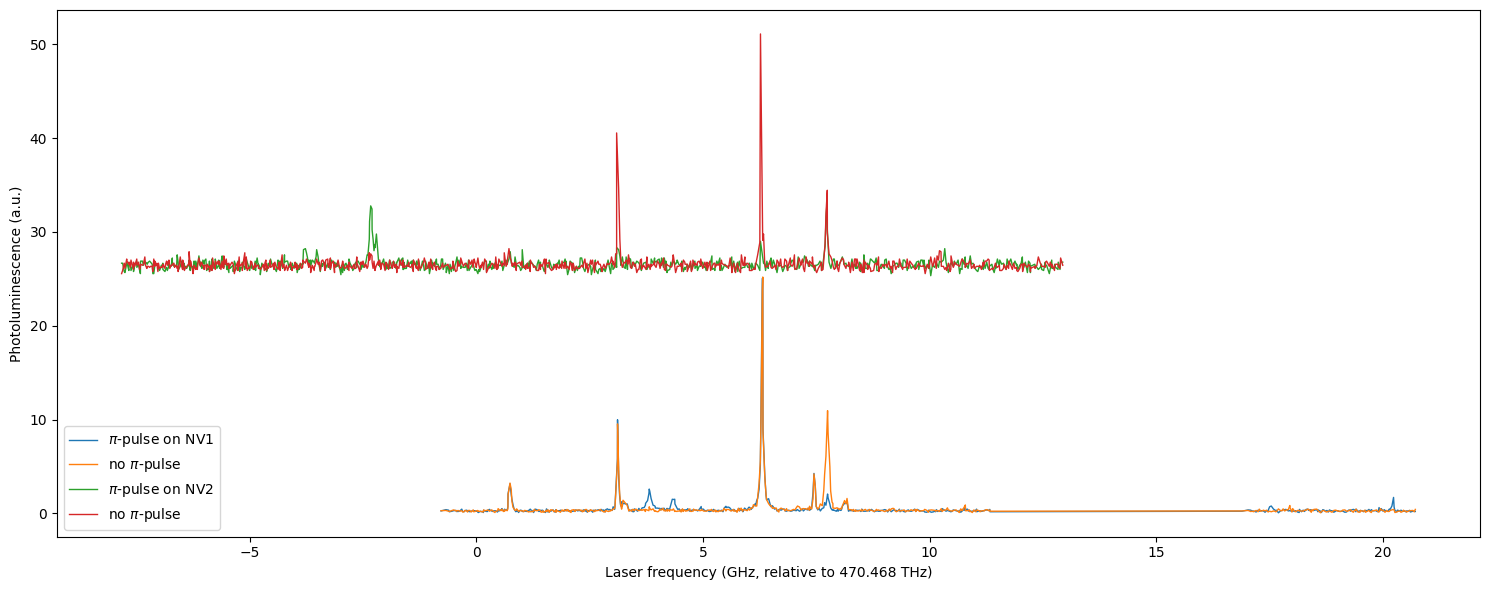

In [507]:
ysig = sig; yref = ref; x = wvl; ms=0; lw = 1; scale = 0.

fig, ax = plt.subplots(1,1, figsize=(15,6)) #

ax.plot(x1Plot, ysig1, 'o-', markersize=ms, linewidth = lw, label='$\pi$-pulse on NV1')
ax.plot(x1Plot, yref1, 'o-', markersize=ms, linewidth = lw, label='no $\pi$-pulse')
ax.plot(x+0.3, ysig+25, 'o-', markersize=ms, linewidth = lw, label='$\pi$-pulse on NV2')
ax.plot(x+0.3, yref+25, 'o-', markersize=ms, linewidth = lw, label='no $\pi$-pulse')
ax.set_ylabel('Photoluminescence (a.u.)')
ax.set_xlabel('Laser frequency (GHz, relative to 470.468 THz)')
ax.legend(loc='lower left')
# ax.set_xlim((-2.9,12.2))

plt.tight_layout()
plt.show()

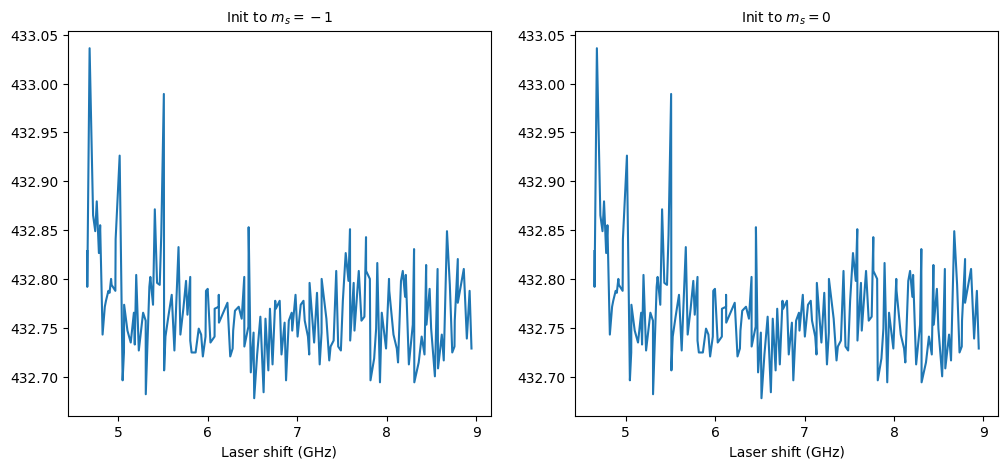

<Figure size 640x480 with 0 Axes>

In [5]:
# ODMR
days = np.linspace(29,29,1)
fig, axs = plt.subplots(1,2,figsize=(12,5))
# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1); separation = 18
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanRRFreqPumpFree_' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 1:# and np.mod(idx,2) == 1: # NV1
                dataArr = []
                datafile = mainFolder + dataFolder +'/ScanRRFreqPumpFreeObject_sig_set.dat'
                x_s, sig, ref, wvl = dr.readDataNoPlotWMJustRef(datafile)
                sig = np.array(sig); ref = np.array(ref); wvl = np.array(wvl)
                wvl=(wvl-470.468)*1e3

                sorted_indices = np.argsort(wvl)
                # Sort array1 in ascending order
                wvl = wvl[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]
                contrast = sig-ref

                if np.mod(idx,2) == 0:
                    sig = sig*4
                    ref = ref*4
                sig=ref-sig
                
                plot1 = axs[0].plot(wvl, sig+separation*idx, marker='o',markersize=0)
                # plot1 = axs[0].plot(x_s, sig+separation*idx)
                axs[0].set_xlabel('Laser shift (GHz)')
                axs[0].set_title('Init to $m_s = -1$',fontsize=10)
                
                plot2 = axs[1].plot(wvl, ref+separation*idx, marker='o',markersize=0)
                axs[1].set_xlabel('Laser shift (GHz)')
                axs[1].set_title('Init to $m_s = 0$',fontsize=10)
                
# for i in range(2):
#     axs[i].set_xlim((5,10))
#     # axs[i].set_ylim((40,44.5))

plt.show()
plt.tight_layout()

In [ ]:
# y = np.average(dataArr, axis=0)
# ysig = np.average(sigArr, axis=0); yref = np.average(refArr, axis=0)
i=0
y = dataArr[i]; ysig = sigArr[i]; yref = refArr[i]

# y = dataArr; ysig = sigArr; yref = refArr
x = np.array(x_s)
# xmin = x[np.argmin(dataArr,axis=1)]
# print(xmin)
# print(np.average(xmin))
# print(np.min(dataArr,axis=1))

fig, axs = plt.subplots(2,1, figsize=(9,4)) #
axs[0].plot(x,y, 'o-', markersize=2, linewidth = 0.5)
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Ref/sig')
axs[0].set_title("Center wavelength = 637.26 nm")

axs[1].plot(x, ysig, 'o-', markersize=2, linewidth = 0.5)
axs[1].plot(x, yref, 'o-', markersize=2, linewidth = 0.5)
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_ylabel('Counts (kc/s)')
# axs[0].set_xlim((70,101))
# # axs[0].set_ylim((-0.01,1))
# axs[1].set_xlim((70,101))

plt.tight_layout()
plt.show()

## For poster

In [1019]:
# ODMR
days = np.linspace(20,20,1)
dataArr2 = []; sigArr2 = []; refArr2 = []; idxs2 = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 713 and idx <= 713):
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s2, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = ref/sig
                dataArr2.append(contrast); sigArr2.append(sig); refArr2.append(ref); idxs2.append(idx)

dataArr2 = np.array(dataArr2); sigArr2 = np.array(sigArr2); refArr2 = np.array(refArr2); idxs2 = np.array(idxs2)

sorted_indices = np.argsort(idxs2)

# Sort array1 in ascending order
dataArr2 = dataArr2[sorted_indices]
sigArr2 = sigArr2[sorted_indices]
refArr2 = refArr2[sorted_indices]

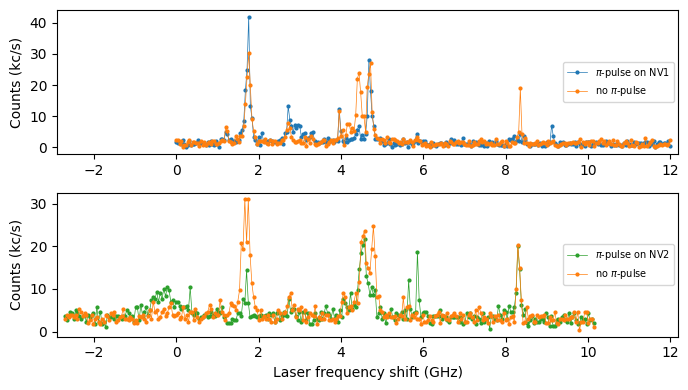

In [1050]:
i=0
y = dataArr[i]; ysig = sigArr[i]; yref = refArr[i]
x = np.array(x_s)
y2 = dataArr2[i]; ysig2 = sigArr2[i]; yref2 = refArr2[i]
x2 = np.array(x_s2)

fig, axs = plt.subplots(2,1, figsize=(7,4)) #

x1Plot = (x-x[0])*0.4
axs[0].plot(x1Plot, ysig, 'o-', markersize=2, linewidth = 0.5, label='$\pi$-pulse on NV1')
axs[0].plot(x1Plot, yref, 'o-', markersize=2, linewidth = 0.5, label='no $\pi$-pulse')
axs[0].set_ylabel('Counts (kc/s)')
axs[0].legend(fontsize=7,loc='right')
axs[0].set_xlim((-2.9,12.2))

x2Plot = x1Plot*1.07-2.7
axs[1].plot(x2Plot, ysig2, 'o-', color='C2',markersize=2, linewidth = 0.5, label='$\pi$-pulse on NV2')
axs[1].plot(x2Plot, yref2, 'o-', color='C1', markersize=2, linewidth = 0.5, label='no $\pi$-pulse')
axs[1].set_xlabel('Laser frequency shift (GHz)')
axs[1].set_ylabel('Counts (kc/s)')
axs[1].set_xlim((-2.9,12.2))
axs[1].legend(fontsize=7,loc='right')

plt.tight_layout()
plt.show()

## With WM

In [332]:
# ODMR
days = np.linspace(28,28,1); whichNV=1
if whichNV==1:
    roundedWvl = 470.485
elif whichNV==2:
    roundedWvl = 470.468
dataArr = []; sigArr = []; refArr = []; idxs = []; wvlArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanRRFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 40 and idx <= 42):
                datafile = mainFolder + dataFolder +'/ScanRRFreqObject_sig_set.dat'
                x_s, sig, ref, wvl = dr.readDataNoPlotWM(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = ref/sig
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)
                idxs.append(idx); wvlArr.append(wvl)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)
idxs = np.array(idxs); wvlArr = (np.array(wvlArr)-roundedWvl)*1e6

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_19304\4198323767.py:20: RuntimeWarning: divide by zero encountered in divide
  contrast = ref/sig


C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_19304\2669177146.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = axs[0].pcolormesh(wvlArr,Y, dataArr, cmap=cmap, norm=norm)
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_19304\2669177146.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot1 = axs[1].pcolormesh(wvlArr,Y, sigArr, cmap='inferno')
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_19304\2669177146.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing.

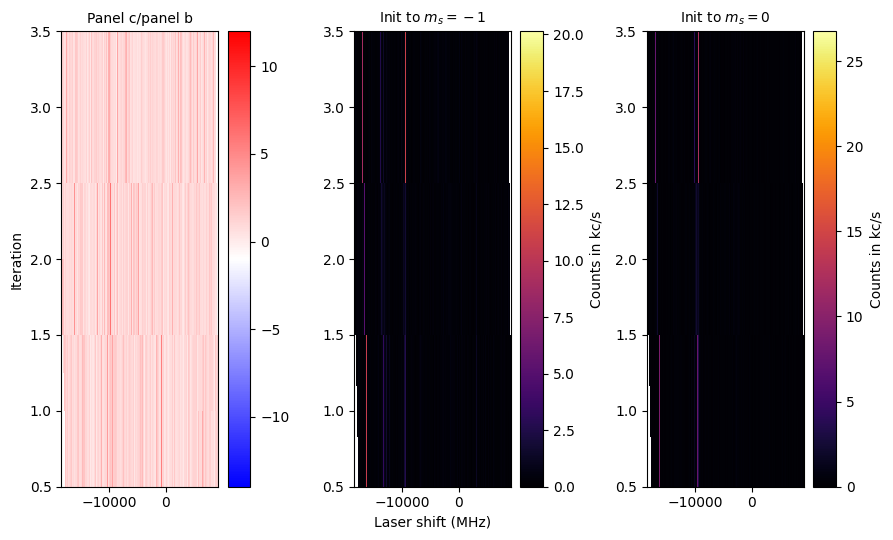

In [333]:
sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]; wvlArr = wvlArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)

fig, axs = plt.subplots(1,3,figsize=(9,5.5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(wvlArr,Y, dataArr, cmap=cmap, norm=norm)
fig.colorbar(plot, orientation='vertical', ax=axs[0])
# axs[0].set_xlabel('Laser shift (MHz)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('Panel c/panel b',fontsize=10)

plot1 = axs[1].pcolormesh(wvlArr,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Laser shift (MHz)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(wvlArr,Y, refArr, cmap='inferno')
# axs[2].set_xlabel('Laser shift (MHz)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

# for i in range(3):
#     axs[i].set_xlim((55,60))
#     # axs[i].set_ylim((0,175))

plt.tight_layout()
plt.show()

# Pulsed ODMR + RR

In [ ]:
# ODMR
days = np.linspace(11,11,1)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-12-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ODMR' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 200 and idx <= 200:
                datafile = mainFolder + dataFolder +'/ODMR_RRObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig/ref
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

plt.show()

[-4.99999991e+04  3.00500000e+09  9.99999986e+05 -5.99999915e+04
  3.00700000e+09  9.99999878e+05 -1.99999965e+04  3.00900000e+09
  9.99999852e+05  6.72424201e-01]


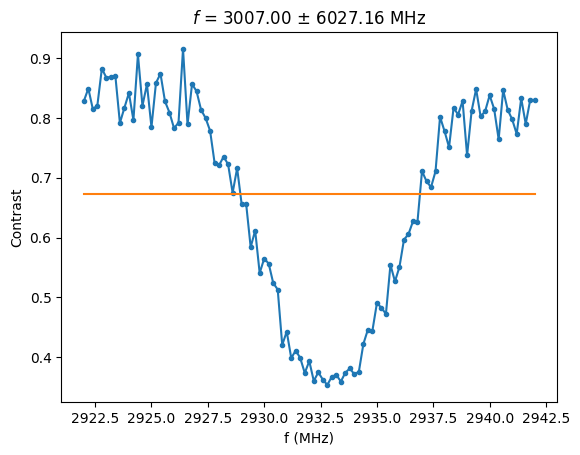

In [171]:
y = np.average(dataArr, axis=0)
x = np.array(x_s)
fig, ax = plt.subplots()
ax.plot(x/1e6,y, 'o-', markersize=3,)
ax.set_xlabel('f (MHz)')
ax.set_ylabel('Contrast')

guess = (-1e3, 3005.5e6, 0.2e6, -4e3, 3007.5e6, 0.2e6, -1e3, 3009.5e6, 0.2e6, 0)
lowerBounds = (-50e3,3005e6,0,   -60e3,3007e6,0,   -20e3,3009e6,0,  -10)
upperBounds = (0,3006e6,1e6,      -1e3,3008e6,1e6,     -1e3,3010e6,1e6,    10)
# ax.plot(x, dr.lorThree(x, *guess), color='g')
xfit, yfit, popt, perr = dr.fitLorThree(x, y, guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
ax.plot(xfit/1e6, yfit, color='C1')
ax.set_title("$f$ = %.2f $\pm$ %.2f MHz" % (popt[4]/1e6, perr[4]/1e6))
print(popt)

threshold = 0.8
peaks = find_peaks(-y, threshold=-threshold)
xpeaks = x[peaks]/1e6

# ax.vlines(x=popt[1], ymin=min(y), ymax=max(y), linestyle='--', color='r')
# ax.vlines(x=xpeaks[0], ymin=min(y), ymax=max(y), linestyle='--', color='r', linewidth=0.4)
# ax.vlines(x=xpeaks[1], ymin=min(y), ymax=max(y), linestyle='--', color='g', linewidth=0.4)
# ax.vlines(x=xpeaks[2], ymin=min(y), ymax=max(y), linestyle='--', color='b', linewidth=0.4)

plt.show()

In [ ]:
fittedPeaks = np.array((np.round(popt[1]/1e6,3),np.round(popt[4]/1e6,3),np.round(popt[7]/1e6,3)))
linewidths = np.array((np.round(popt[2]/1e3,2),np.round(popt[5]/1e3,2),np.round(popt[8]/1e3,2)))
print(xpeaks)
print("Fitted peaks (MHz)", fittedPeaks)
print("Deviation from drive at 3007.6 MHz", np.abs(3007.6-fittedPeaks))
print("Linewidths (kHz)", linewidths)

# Rabi

In [ ]:
datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1620_RabiRR_17-11-16/RabiRRObject_sig_set.dat'
datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1630_RabiRR_17-36-25/RabiRRObject_sig_set.dat'
# datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1648_RabiRR_17-42-54/RabiRRObject_sig_set.dat'
guess=(0.2, 60, 0, 0.9, 600)
sig, ref, popt, perr, x_s = dr.readData(datafile, type='RabiDecay', ifFit=1, guess=guess)

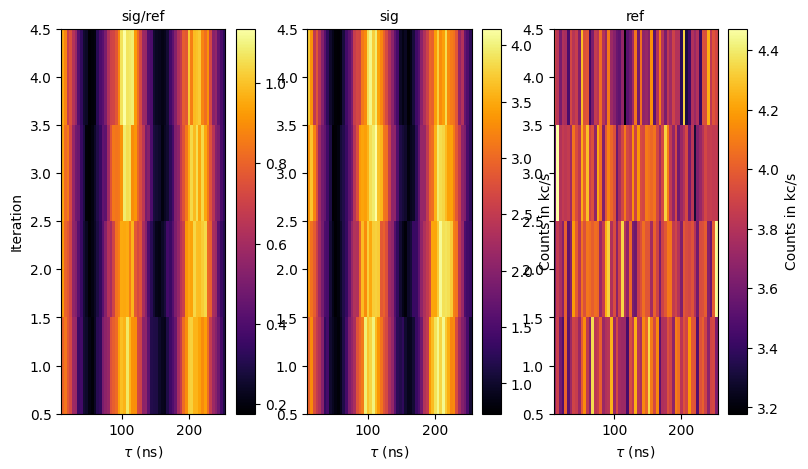

In [191]:
# Rabi
days = np.linspace(11,11,1)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-12-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRR' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (idx >= 276 and idx <= 279) and np.mod(idx,1)==0:
                datafile = mainFolder + dataFolder +'/RabiRRObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                
                xPlot = x_s
                contrast = sig/ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('sig/ref',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)
# plot1.set_clim(0,4)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

# for i in range(3):
#     # axs[i].set_xlim((82,84))
#     axs[i].set_ylim((600,610))

plt.show()
plt.tight_layout()


<Figure size 640x480 with 0 Axes>

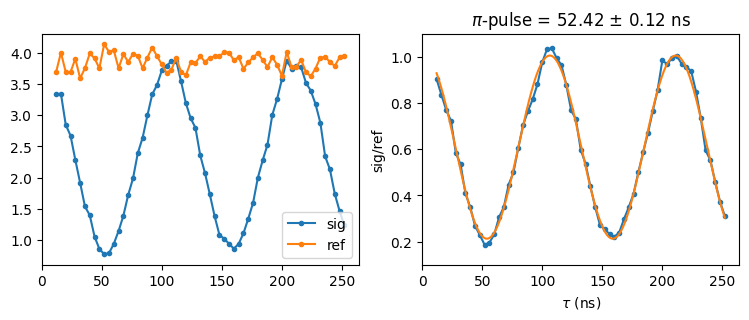

In [192]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(9,3))
    axs[1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[1].set_ylabel('sig/ref')
    axs[1].set_xlabel(r"$\tau$ (ns)")
    axs[1].set_ylim((0.1,1.1))

    axs[0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    # axs[0].set_title(datafile[31:-25],fontsize=10)

    guess = (0.66, 50, 0, 0.9, 600)


    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[1].plot(xfit, yfit, color='C1')
    axs[1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
plt.show()

# Dual Rabi

In [9]:
# Rabi
days = np.linspace(21,21,1); whichNVIsReadFirst=1
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRODualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx>=28 and idx <= 30:
                datafile = mainFolder + dataFolder +'/RabiRODualNVObject_sig2_set.dat'
                if whichNVIsReadFirst==1:
                    x_s, sig2, ref2, sig, ref = dr.readDataNoPlotDual(datafile)
                elif whichNVIsReadFirst==2:
                    x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                xPlot = x_s
                contrast = sig/ref; contrast2 = sig2/ref2
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

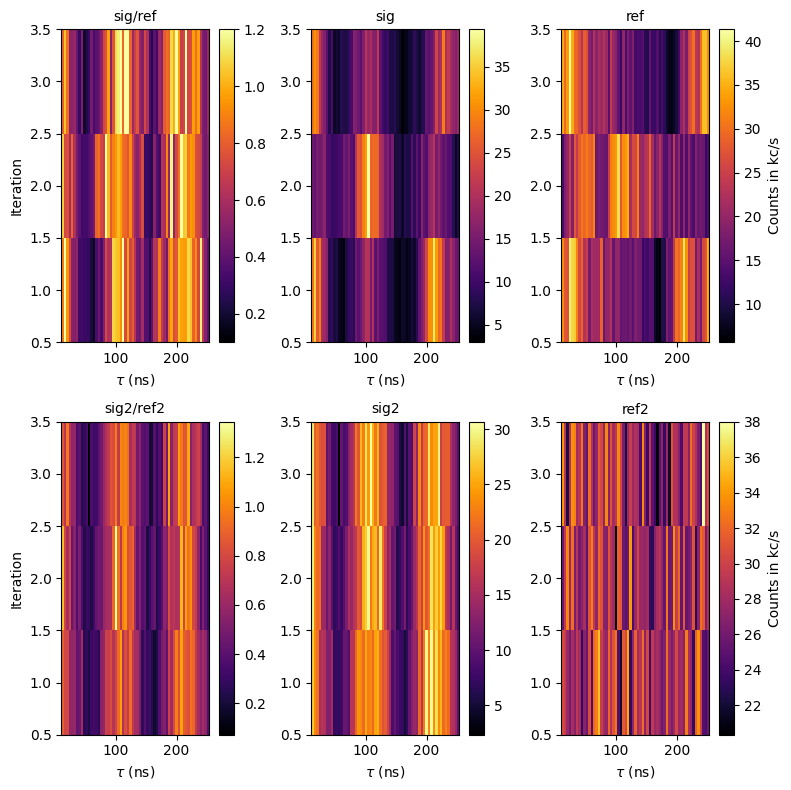

In [10]:
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]; sigArr = sigArr[sorted_indices]; refArr = refArr[sorted_indices]
data2Arr = data2Arr[sorted_indices]; sig2Arr = sig2Arr[sorted_indices]; ref2Arr = ref2Arr[sorted_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_xlabel('$\\tau$ (ns)')
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('sig/ref',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_xlabel('$\\tau$ (ns)')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_xlabel('$\\tau$ (ns)')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ (ns)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('sig2/ref2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ (ns)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ (ns)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plt.tight_layout()
plt.show()


[4.19068075e-01 5.30570181e+01 5.21802695e-02 6.95073484e-01
 5.87244570e+02]
[ 3.39326492e-01  5.23543821e+01 -1.63272924e-01  6.04418448e-01
  7.49671191e+03]


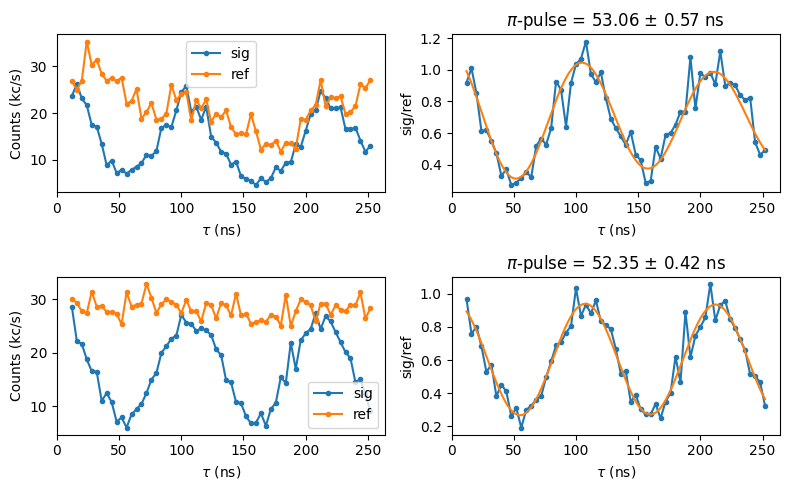

In [11]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    x = xPlot
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[0,1].set_ylabel('sig/ref')
    axs[0,1].set_xlabel(r"$\tau$ (ns)")
    # axs[0,1].set_ylim((0.15,1.2))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_xlabel(r"$\tau$ (ns)")
    axs[0,0].set_ylabel('Counts (kc/s)')

    guess = (0.66, 50, 0, 0.9, 600)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[0,1].plot(xfit, yfit, color='C1')
    axs[0,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    print(popt)

    ################################################################################
    axs[1,1].plot(x,y2, 'o-', markersize=3, label="sig/ref")
    axs[1,1].set_ylabel('sig/ref')
    axs[1,1].set_xlabel(r"$\tau$ (ns)")
    # axs[1,1].set_ylim((0.15,1.2))

    axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig")
    axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ (ns)")
    axs[1,0].set_ylabel('Counts (kc/s)')

    guess = (0.66, 50, 0, 0.9, 600)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y2, guess=guess)
    axs[1,1].plot(xfit, yfit, color='C1')
    axs[1,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    print(popt)

plt.tight_layout()
plt.show()

In [181]:
# SCC + RR
days = np.linspace(30,30,1)
name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-12-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if name1 in dataFolder:
            idx = int(dataFolder[1:4])
            if idx==148:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder + name2
                ti = 2700; tr_ns = 1e6

                # taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                sigArr.append(sig); refArr.append(ref)
                sig2Arr.append(sig2); ref2Arr.append(ref2)

sigArr = np.array(sigArr); refArr = np.array(refArr); 
sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

sigArr = sigArr.reshape(1,-1); refArr = refArr.reshape(1,-1)
sig2Arr = sig2Arr.reshape(1,-1); ref2Arr = ref2Arr.reshape(1,-1)
dataArr = sigArr/refArr; data2Arr = sig2Arr/ref2Arr

dataArr = np.nan_to_num(dataArr); data2Arr = np.nan_to_num(data2Arr)
dataArr = np.where(dataArr > 1e3, 0, dataArr)
data2Arr = np.where(data2Arr > 1e3, 0, data2Arr)

xPlot = np.linspace(1,len(sigArr[0]),len(sigArr[0]))



C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_30516\1892221121.py:33: RuntimeWarning: divide by zero encountered in divide
  dataArr = sigArr/refArr; data2Arr = sig2Arr/ref2Arr
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_30516\1892221121.py:33: RuntimeWarning: invalid value encountered in divide
  dataArr = sigArr/refArr; data2Arr = sig2Arr/ref2Arr


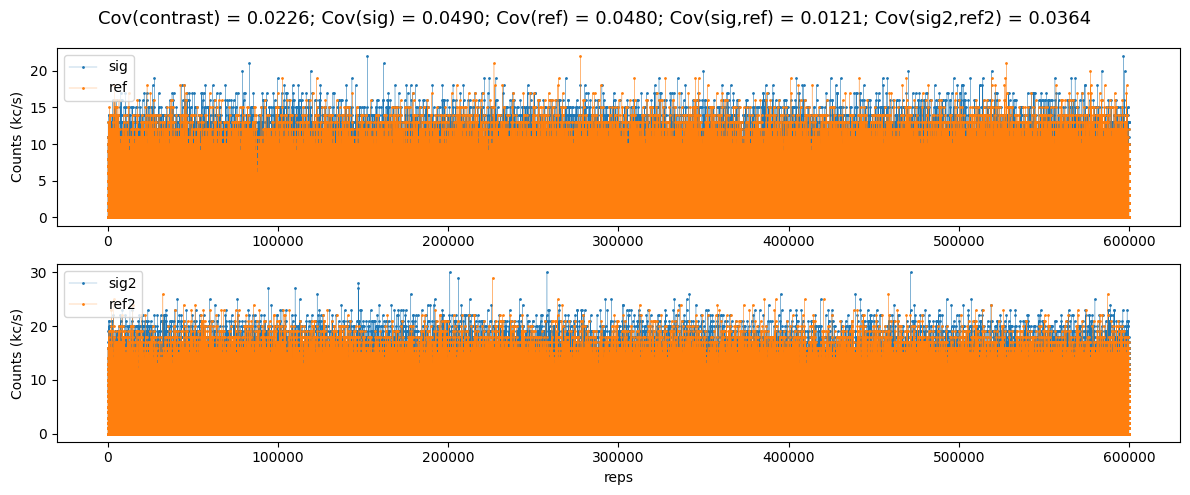

In [182]:
axis=1
a=cov(dataArr,data2Arr,axis=axis)
b=cov(sigArr,sig2Arr,axis=axis)
c=cov(refArr,ref2Arr,axis=axis)
d=cov(sigArr,refArr,axis=axis)
e=cov(sig2Arr,ref2Arr,axis=axis)

x = xPlot
y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

fig, axs = plt.subplots(2,1,figsize=(12,5))

axs[0].plot(x, ys, 'o-', linewidth=0.2,markersize=1, label="sig")
axs[0].plot(x, yr, 'o-', linewidth=0.2,markersize=1, label="ref")
axs[0].legend()
axs[0].set_ylabel('Counts (kc/s)')

################################################################################
axs[1].plot(x, ys2, 'o-', linewidth=0.2,markersize=1, label="sig2")
axs[1].plot(x, yr2, 'o-', linewidth=0.2,markersize=1, label="ref2")
axs[1].legend()
axs[1].set_xlabel(r"reps")
axs[1].set_ylabel('Counts (kc/s)')

fig.suptitle('Cov(contrast) = %.4f; Cov(sig) = %.4f; Cov(ref) = %.4f; Cov(sig,ref) = %.4f; Cov(sig2,ref2) = %.4f' % (a,b,c,d,e), fontsize=13)
plt.tight_layout()
plt.show()

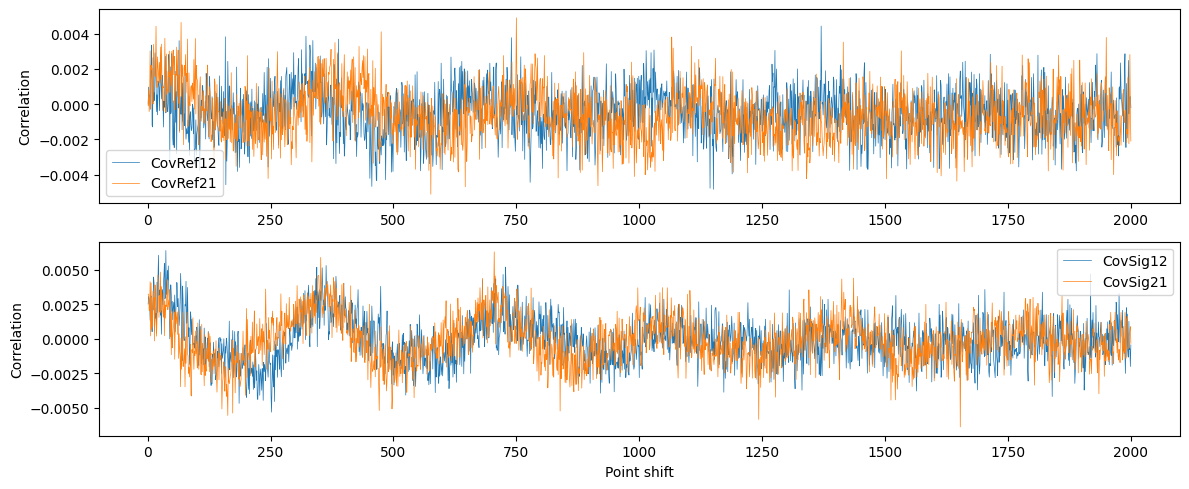

In [185]:
m=0; n=None; N=2000; Nend = N
x = np.linspace(1,Nend,N)
shiftedCovRef12 = []; shiftedCovRef21 = []; shiftedCovContrast12 = []; shiftedCovContrast21 = []; 
shiftedCovSig12 = []; shiftedCovSig21 = []
axis=0; linewidth = 0.5; 

yr = yr[m:n]; yr2 = yr2[m:n]; y = y[m:n]; y2 = y2[m:n]

# for k in x:
#     shiftedCovRef12.append(cov(yr[0:-int(k)], yr2[int(k):],axis=axis))
#     shiftedCovRef21.append(cov(yr2[0:-int(k)],yr[int(k):],axis=axis))
#     shiftedCovContrast12.append(cov(y[0:-int(k)], y2[int(k):],axis=axis))
#     shiftedCovContrast21.append(cov(y2[0:-int(k)],y[int(k):],axis=axis))
for k in x:
    k=int(k)
    shiftedCovRef12.append(cov(yr, circular_shift(yr2,k),axis=axis))
    shiftedCovRef21.append(cov(yr2, circular_shift(yr,k),axis=axis))
    shiftedCovSig12.append(cov(ys, circular_shift(ys2,k),axis=axis))
    shiftedCovSig21.append(cov(ys2, circular_shift(ys,k),axis=axis))
    # shiftedCovContrast12.append(cov(y, circular_shift(y2,k),axis=axis))
    # shiftedCovContrast21.append(cov(y2, circular_shift(y,k),axis=axis))
shiftedCovRef12 = np.array(shiftedCovRef12); shiftedCovRef21 = np.array(shiftedCovRef21)
shiftedCovSig12 = np.array(shiftedCovSig12); shiftedCovSig21 = np.array(shiftedCovSig21)
# shiftedCovContrast12 = np.array(shiftedCovContrast12); shiftedCovContrast21 = np.array(shiftedCovContrast21)

fig,axs = plt.subplots(2,1,figsize=(12,5))
axs[0].plot(x,shiftedCovRef12,label="CovRef12",linewidth=linewidth)
axs[0].plot(x,shiftedCovRef21,label="CovRef21",linewidth=linewidth)
axs[0].set_ylabel('Correlation')
axs[0].legend()

# axs[1].plot(x,shiftedCovContrast12,label="CovContrast12",linewidth=linewidth)
# axs[1].plot(x,shiftedCovContrast21,label="CovContrast21",linewidth=linewidth)
# axs[1].set_ylabel('Correlation')
# axs[1].legend()

axs[1].plot(x,shiftedCovSig12,label="CovSig12",linewidth=linewidth)
axs[1].plot(x,shiftedCovSig21,label="CovSig21",linewidth=linewidth)
axs[1].set_ylabel('Correlation')
axs[1].legend()

axs[1].set_xlabel('Point shift')
plt.tight_layout()

# Restore to full length
y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

Peaks (Hz) [0.331]
Peaks (Hz) [0.331]


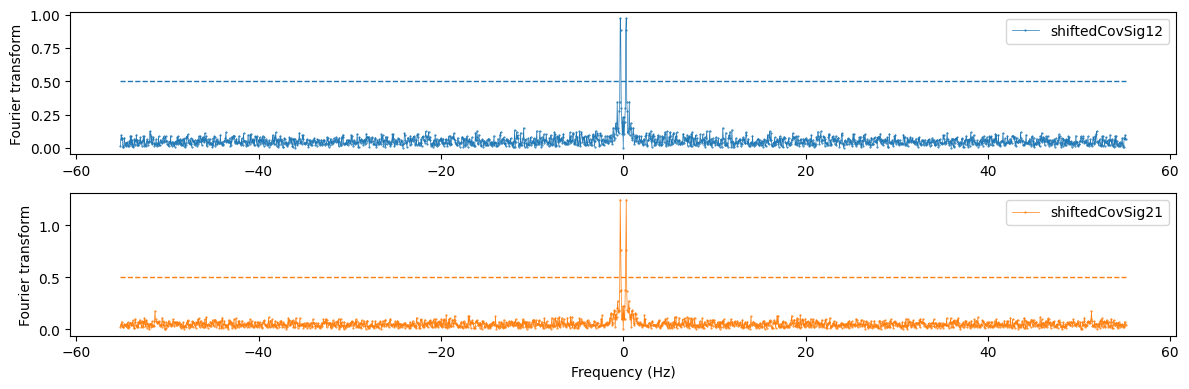

In [186]:
refOrSig = 'sig'; delta_t = 18.128544/2e3; factor=1
if refOrSig =='ref':
    f, yfourier  = fourier(shiftedCovRef12, delta_t=delta_t,f_factor=factor)
    f2,yfourier2 = fourier(shiftedCovRef21, delta_t=delta_t,f_factor=factor)
    label1 = 'shiftedCovRef12'; label2 = 'shiftedCovRef21'
elif refOrSig =='sig':
    f, yfourier  = fourier(shiftedCovSig12, delta_t=delta_t,f_factor=factor)
    f2,yfourier2 = fourier(shiftedCovSig21, delta_t=delta_t,f_factor=factor)
    label1 = 'shiftedCovSig12'; label2 = 'shiftedCovSig21'

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(12,4))

axs[0].plot(f, yfourier, linestyle='-', marker='o', linewidth=0.5, markersize=0.5, color='C0', label=label1)
axs[0].set_title('')
axs[0].set_ylabel('Fourier transform')
axs[0].legend()
# axs[0].set_ylim((0,1))

axs[1].plot(f2, yfourier2, linestyle='-', marker='o', linewidth=0.5, markersize=0.5, color='C1', label=label2)
axs[1].set_title('')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Fourier transform')
axs[1].legend()
# axs[1].set_ylim((0,1))

threshold = .5
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (Hz)', np.round(fpeaks,3))

threshold2 = .5
peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print('Peaks (Hz)', np.round(fpeaks2,3))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1, color='C1')

plt.tight_layout()

In [ ]:
ms = np.linspace(0,460000,101); n=2000; N=int(n/2); delta_t = 26.128544/2e3; factor=1
shiftedCovRef12_2d = []; shiftedCovRef21_2d = []; shiftedCovSig12_2d = []; shiftedCovSig21_2d = []
yFFTShiftedCovRef12_2d = []; yFFTShiftedCovRef21_2d = []; yFFTShiftedCovSig12_2d = []; yFFTShiftedCovSig21_2d = []
for m in ms:
    shiftedCovRef12 = []; shiftedCovRef21 = []; shiftedCovContrast12 = []; shiftedCovContrast21 = []; 
    shiftedCovSig12 = []; shiftedCovSig21 = []
    axis=0; linewidth = 0.5; m=int(m)

    yr = yr[m:m+n]; yr2 = yr2[m:m+n]; ys = y[m:m+n]; ys2 = y2[m:m+n]; y = y[m:m+n]; y2 = y2[m:m+n]

    # for k in np.linspace(1,N,N):
    #     shiftedCovRef12.append(cov(yr[0:-int(k)], yr2[int(k):],axis=axis))
    #     shiftedCovRef21.append(cov(yr2[0:-int(k)],yr[int(k):],axis=axis))
    #     shiftedCovContrast12.append(cov(y[0:-int(k)], y2[int(k):],axis=axis))
    #     shiftedCovContrast21.append(cov(y2[0:-int(k)],y[int(k):],axis=axis))
    for k in np.linspace(1,N,N):
        k=int(k)
        shiftedCovRef12.append(cov(yr, circular_shift(yr2,k),axis=axis))
        shiftedCovRef21.append(cov(yr2, circular_shift(yr,k),axis=axis))
        shiftedCovSig12.append(cov(ys, circular_shift(ys2,k),axis=axis))
        shiftedCovSig21.append(cov(ys2, circular_shift(ys,k),axis=axis))
        # shiftedCovContrast12.append(cov(y, circular_shift(y2,k),axis=axis))
        # shiftedCovContrast21.append(cov(y2, circular_shift(y,k),axis=axis))

    shiftedCovRef12 = np.array(shiftedCovRef12); shiftedCovRef21 = np.array(shiftedCovRef21)
    shiftedCovSig12 = np.array(shiftedCovSig12); shiftedCovSig21 = np.array(shiftedCovSig21)
    # shiftedCovContrast12 = np.array(shiftedCovContrast12); shiftedCovContrast21 = np.array(shiftedCovContrast21)

    f, yFFTShiftedCovRef12 = fourier(shiftedCovRef12, delta_t=delta_t,f_factor=factor)
    f, yFFTShiftedCovRef21 = fourier(shiftedCovRef21, delta_t=delta_t,f_factor=factor)
    f, yFFTShiftedCovSig12 = fourier(shiftedCovSig12, delta_t=delta_t,f_factor=factor)
    f, yFFTShiftedCovSig21 = fourier(shiftedCovSig21, delta_t=delta_t,f_factor=factor)
    
    shiftedCovRef12_2d.append(shiftedCovRef12); shiftedCovRef21_2d.append(shiftedCovRef21)
    shiftedCovSig12_2d.append(shiftedCovSig12); shiftedCovSig21_2d.append(shiftedCovSig21)
    yFFTShiftedCovRef12_2d.append(yFFTShiftedCovRef12); yFFTShiftedCovRef21_2d.append(yFFTShiftedCovRef21)
    yFFTShiftedCovSig12_2d.append(yFFTShiftedCovSig12); yFFTShiftedCovSig21_2d.append(yFFTShiftedCovSig21)

    # Restore to full length
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

shiftedCovRef12_2d = np.array(shiftedCovRef12_2d); shiftedCovRef21_2d = np.array(shiftedCovRef21_2d)
shiftedCovSig12_2d = np.array(shiftedCovSig12_2d); shiftedCovSig21_2d = np.array(shiftedCovSig21_2d)
yFFTShiftedCovRef12_2d = np.array(yFFTShiftedCovRef12_2d); yFFTShiftedCovRef21_2d = np.array(yFFTShiftedCovRef21_2d)
yFFTShiftedCovSig12_2d = np.array(yFFTShiftedCovSig12_2d); yFFTShiftedCovSig21_2d = np.array(yFFTShiftedCovSig21_2d)
#####################################################################################################################
x = np.linspace(1,N,N)
X, Y = np.meshgrid(x, ms)
fig,axs = plt.subplots(2,1,figsize=(12,5))
norm = TwoSlopeNorm(vmin=-0.03, vcenter=0, vmax=0.03)
plot0 = axs[0].pcolormesh(X,Y,shiftedCovRef12_2d,cmap='bwr',norm=norm)
plot1 = axs[1].pcolormesh(X,Y,shiftedCovRef21_2d,cmap='bwr',norm=norm)

cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0])
cb0.set_label("Correlation",fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Correlation",fontsize=10)

axs[0].set_ylabel('Starting index, covRef12')
axs[1].set_ylabel('Starting index, covRef21')
axs[1].set_xlabel('Point shift')
fig.suptitle('Correlation within a group of $n$ = ' + str(n) + ' reps, ref', fontsize=13)
plt.tight_layout()

#####################################################################################################################
fig,axs = plt.subplots(2,1,figsize=(12,5))
plot0 = axs[0].pcolormesh(X,Y,shiftedCovSig12_2d,cmap='bwr',norm=norm)
plot1 = axs[1].pcolormesh(X,Y,shiftedCovSig21_2d,cmap='bwr',norm=norm)

cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0])
cb0.set_label("Correlation",fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Correlation",fontsize=10)

axs[0].set_ylabel('Starting index, covSig12')
axs[1].set_ylabel('Starting index, covSig21')
axs[1].set_xlabel('Point shift')
fig.suptitle('Correlation within a group of $n$ = ' + str(n) + ' reps, sig', fontsize=13)
plt.tight_layout()
#####################################################################################################################
X, Y = np.meshgrid(f, ms)
fig,axs = plt.subplots(2,1,figsize=(12,5))
plot0 = axs[0].pcolormesh(X,Y,yFFTShiftedCovRef12_2d,cmap='inferno')
plot1 = axs[1].pcolormesh(X,Y,yFFTShiftedCovRef21_2d,cmap='inferno')

cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0])
cb0.set_label("FFT amplitude",fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("FFT amplitude",fontsize=10)

axs[0].set_ylabel('Starting index, covRef12')
axs[1].set_ylabel('Starting index, covRef21')
axs[1].set_xlabel('f (Hz)')
fig.suptitle('Correlation within a group of $n$ = ' + str(n) + ' reps, ref', fontsize=13)
plt.tight_layout()
#####################################################################################################################
X, Y = np.meshgrid(f, ms)
fig,axs = plt.subplots(2,1,figsize=(12,5))
plot0 = axs[0].pcolormesh(X,Y,yFFTShiftedCovSig12_2d,cmap='inferno')
plot1 = axs[1].pcolormesh(X,Y,yFFTShiftedCovSig21_2d,cmap='inferno')

cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0])
cb0.set_label("FFT amplitude",fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("FFT amplitude",fontsize=10)

axs[0].set_ylabel('Starting index, covSig12')
axs[1].set_ylabel('Starting index, covSig21')
axs[1].set_xlabel('f (Hz)')
fig.suptitle('Correlation within a group of $n$ = ' + str(n) + ' reps, sig', fontsize=13)
plt.tight_layout()

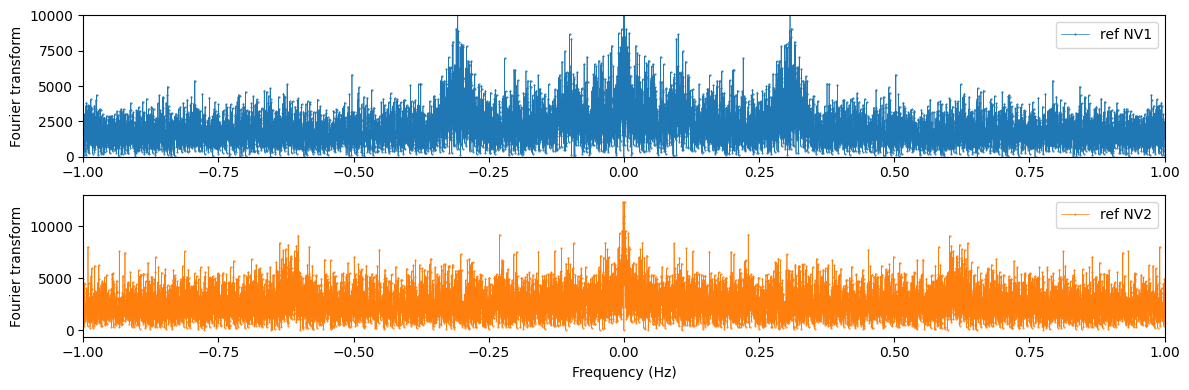

In [189]:
delta_t = 18.128544/2e3; factor=1
f,yfourier = fourier(yr, delta_t=delta_t,f_factor=factor)
f2,yfourier2 = fourier(yr2, delta_t=delta_t,f_factor=factor)

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(12,4))

axs[0].plot(f, yfourier, linestyle='-', marker='o', linewidth=0.5, markersize=0.5, color='C0', label='ref NV1')
axs[0].set_title('')
axs[0].set_ylabel('Fourier transform')
axs[0].legend()
axs[0].set_xlim((-1,1))
axs[0].set_ylim((-1,10000))

axs[1].plot(f2, yfourier2, linestyle='-', marker='o', linewidth=0.5, markersize=0.5, color='C1', label='ref NV2')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Fourier transform')
axs[1].legend()
axs[1].set_xlim((-1,1))

# threshold = 8000
# peaks = find_peaks(yfourier, threshold=threshold)
# fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
# print('Peaks (Hz)', np.round(fpeaks,3))

# threshold2 = 8300
# peaks2 = find_peaks(yfourier2, threshold=threshold2)
# fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
# print('Peaks (Hz)', np.round(fpeaks2,3))

# axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
# axs[1].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1, color='C1')

plt.tight_layout()

Peaks (Hz) [0.    0.001 0.001]


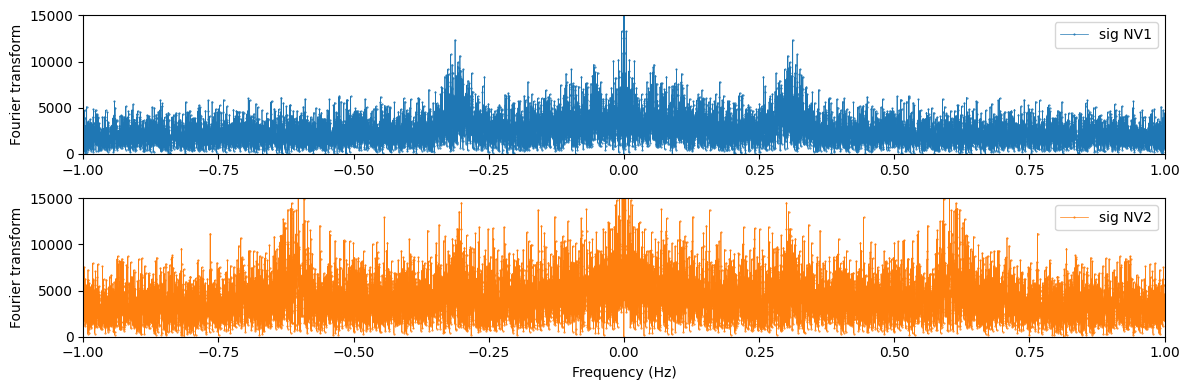

In [191]:
delta_t = 18.128544/2e3; factor=1
f,yfourier = fourier(ys, delta_t=delta_t,f_factor=factor)
f2,yfourier2 = fourier(ys2, delta_t=delta_t,f_factor=factor)

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(12,4))

axs[0].plot(f, yfourier, linestyle='-', marker='o', linewidth=0.5, markersize=0.5, color='C0', label='sig NV1')
axs[0].set_title('')
axs[0].set_ylabel('Fourier transform')
axs[0].legend()
axs[0].set_xlim((-1,1))
axs[0].set_ylim((-1,15000))

axs[1].plot(f2, yfourier2, linestyle='-', marker='o', linewidth=0.5, markersize=0.5, color='C1', label='sig NV2')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Fourier transform')
axs[1].legend()
axs[1].set_xlim((-1,1))
axs[1].set_ylim((-1,15000))

# threshold = 10000
# peaks = find_peaks(yfourier, threshold=threshold)
# fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
# print('Peaks (Hz)', np.round(fpeaks,3))

threshold2 = 30000
peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print('Peaks (Hz)', np.round(fpeaks2,3))

# axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1, color='C1')

plt.tight_layout()

# T2E RR

## Randomized scan

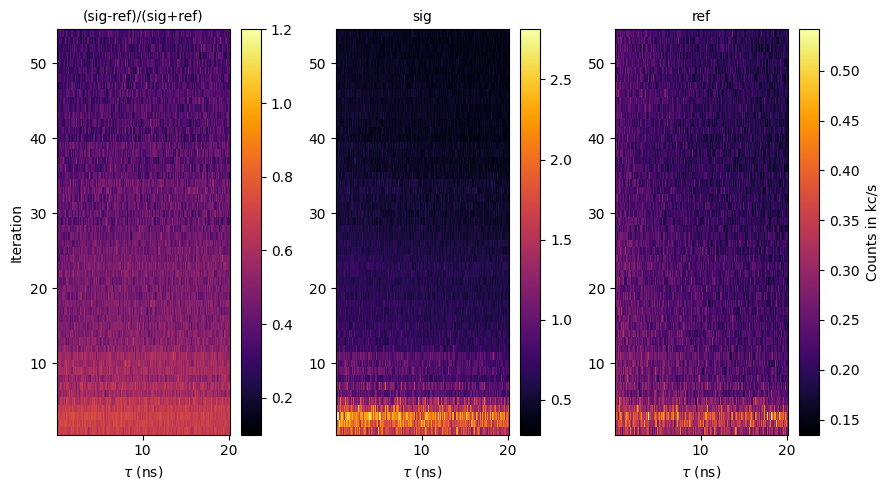

In [1237]:
# November T2E
days = np.linspace(21,21,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-12-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2ERR' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (((idx >= 993 and idx <= 1058) or (idx >= 1265 and idx <= 1488)) and np.mod(idx,2) == 1) or (((idx >= 1058 and idx <= 1264) or (idx >= 1488 and idx <= 1861)) and np.mod(idx,2) == 0):
            if idx >= 145 and idx <= 1445:
                datafile = mainFolder + dataFolder +'/T2EROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)

                sig = np.array(sig); ref = np.array(ref)
                contrast = (sig-ref)/(sig+ref)
                xPlot = x_s; xPlot = np.array(xPlot)

                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                contrast = contrast[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('(sig-ref)/(sig+ref)',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

In [ ]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(0,3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[1].plot(x/1e3,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    axs[1].set_ylabel('(sig-ref)/(sig+ref)')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    # axs[1].set_xlim((-5,110))

    axs[0].plot(x/1e3, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x/1e3, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    axs[0].set_ylabel('Counts (kc/s)')
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')

    plt.tight_layout()

In [ ]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 100e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(8,3))
axs[0].plot(x,y, 'o-', markersize=3,)
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
# axs[1].set_ylim((0,10))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.5
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

## Dual T2E

In [ ]:
# T2E NV2 first
days = np.linspace(21,21,1)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-12-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T2ERRDualNV_NewTrack' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 491 and idx <= 496) or (idx>=531 and idx<=541):
            if idx >= 547 and idx <= 564:
                datafile = mainFolder + dataFolder +'/T2ERRDualNV_NewTrackObject_sig2_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)


In [50]:
# T2E/XY8
days = np.linspace(9,22,14)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'XY8RRDualNV_NewTrack' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if day == 7 and idx <= 26:
            # if day == 11 and idx >= 31 and idx <= 119:
            # if day == 12 and idx >= 40 and idx <= 66:
            # if day == 13 and idx >= 53 and idx <= 55:
            # if day == 14 and idx >= 26 and idx <= 109:
            # if day == 15 and idx >= 31 and idx <= 106:
            if day == 20 and idx >= 40 or day == 21 and idx <= 7:
            # if day == 21 and idx >= 9 and idx <= 31:
            # if (day==21 and idx >= 97) or (day==22 and idx<=112): # for December T2E
                datafile = mainFolder + dataFolder +'/XY8RRDualNV_NewTrackObject_sig_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

(19, 93)


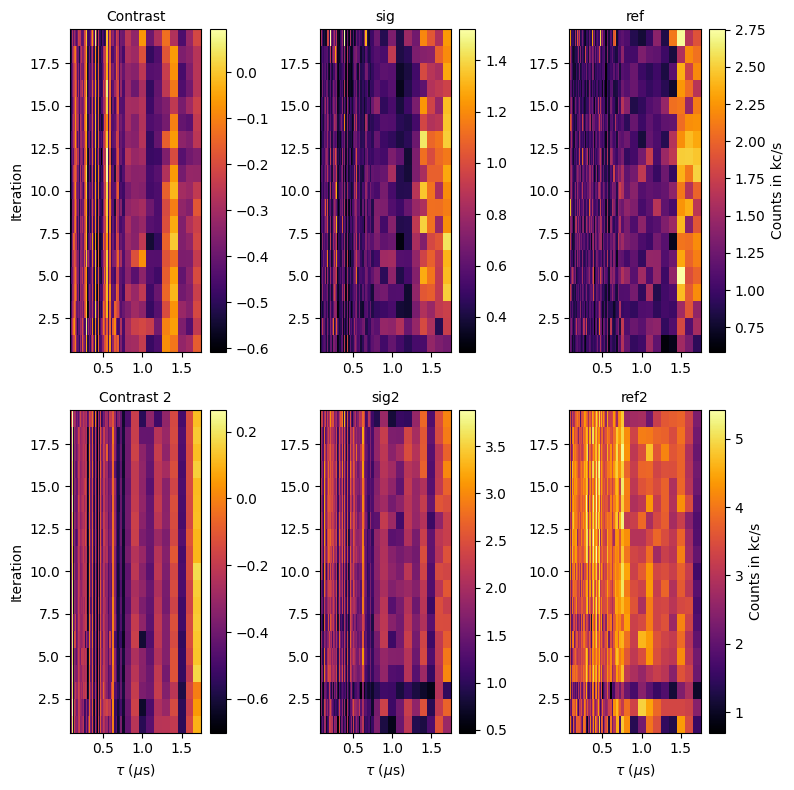

In [51]:
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
nan_indices = np.isnan(data2Arr)
data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('Contrast',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('Contrast 2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plt.tight_layout()


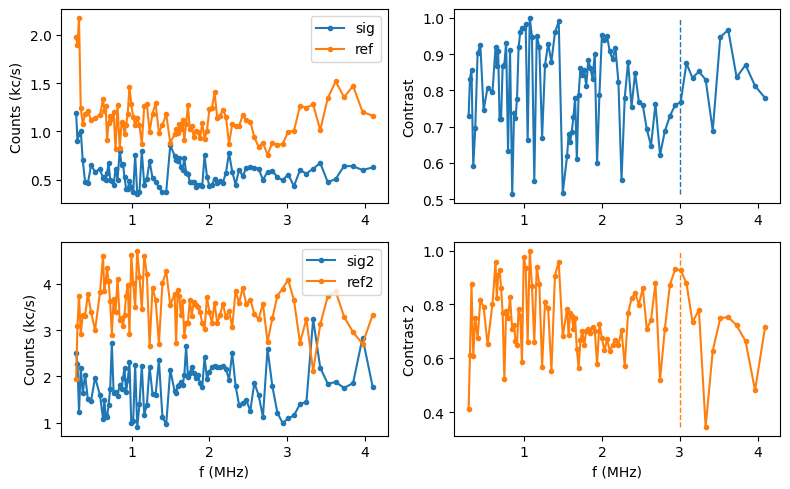

In [53]:
ifXAxisFreq = 1; correctionToTau = 42; markerAt = 3; ifSketchyNorm=1
def linear_map(arr, a, b, c, d):
    return (arr - a) * (d - c) / (b - a) + c
for idxs in np.linspace(6,8,1):
    idx = int(idxs)
    t = xPlot+correctionToTau
    x = (xPlot+correctionToTau)/1e3
    if ifXAxisFreq: x = 1/(2*(xPlot+correctionToTau)*1e-3)
    
    # y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    # y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    if ifSketchyNorm != 0:
        y=-y;y2=-y2
        y = linear_map(y,-(y.max()),y.max(),0,1)
        y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)

        # c1_OldRR_XY85 = y; c2_OldRR_XY852 = y2
        # c1t = y; c2t = y2
        # y = (y-y.min())/(y.max()-y.min())
        # y2 = (y2-y2.min())/(y2.max()-y2.min())

        # y = -np.log(y)/(t*1e-3)
        # y2 = -np.log(y2)/(t*1e-3)
    if True:
        fig, axs = plt.subplots(2,2,figsize=(8,5))
        axs[0,1].plot(x,y, 'o-', markersize=3, label="contrast")
        axs[0,1].set_ylabel('Contrast')
        axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--',linewidth=1)
        # axs[0,1].set_xlim((-0.1,4))
        # axs[0,1].set_ylim((0.47,0.61))

        axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
        axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
        axs[0,0].legend()
        axs[0,0].set_ylabel('Counts (kc/s)')

        ################################################################################
        axs[1,1].plot(x,y2, 'o-', markersize=3, color='C1',label="contrast 2")
        axs[1,1].set_ylabel('Contrast 2')
        axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
        axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), color='C1',linestyle='--',linewidth=1)
        if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
        # axs[1,1].set_xlim((-0.1,5.1))

        axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig2")
        axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref2")
        axs[1,0].legend()
        axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
        if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
        axs[1,0].set_ylabel('Counts (kc/s)')

        # axs[0,1].set_xscale('log')
        # axs[1,1].set_xscale('log')

    plt.tight_layout()

In [30]:
yNoise=y;yNoise2=y2

In [34]:
yOldRR_XY85=y
yOldRR_XY852=y2

In [38]:
yOldRR=y
yOldRR2=y2

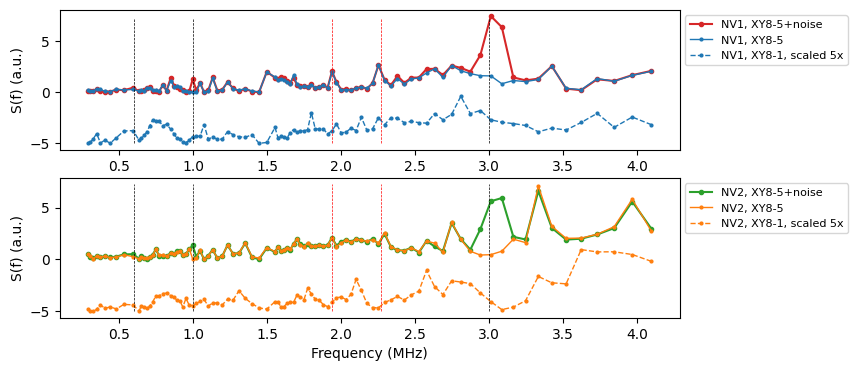

In [40]:
# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(8,4))

axs[0].plot(x,yNoise, linestyle='-', marker='o', markersize=3, color='C3', label='NV1, XY8-5+noise')
axs[0].plot(x,yOldRR_XY85, linestyle='-', linewidth=1, marker='o', markersize=2, color='C0', label='NV1, XY8-5')
axs[0].plot(x,(yOldRR-1)*5, linestyle='--', linewidth=1, marker='o', markersize=2, color='C0', label='NV1, XY8-1, scaled 5x')

axs[0].set_title('')
axs[0].set_ylabel('S(f) (a.u.)')
axs[0].legend(fontsize=8,loc='upper left', bbox_to_anchor=(1, 1))
# axs[0].set_yscale('log')

axs[1].plot(x,yNoise2, linestyle='-', marker='o', markersize=3, color='C2', label='NV2, XY8-5+noise')
axs[1].plot(x,yOldRR_XY852, linestyle='-', linewidth=1, marker='o', markersize=2, color='C1', label='NV2, XY8-5')
axs[1].plot(x,(yOldRR2-1)*5, linestyle='--', linewidth=1, marker='o', markersize=2, color='C1', label='NV2, XY8-1, scaled 5x')

axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('S(f) (a.u.)')
axs[1].legend(fontsize=8,loc='upper left', bbox_to_anchor=(1, 1))

axs[1].vlines(x=3, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
axs[1].vlines(x=1, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
axs[1].vlines(x=0.6, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
axs[0].vlines(x=3, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
axs[0].vlines(x=1, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
axs[0].vlines(x=0.6, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')

axs[0].vlines(x=1.94, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')
axs[1].vlines(x=1.94, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')

axs[0].vlines(x=2.27, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')
axs[1].vlines(x=2.27, ymin=min(yOldRR2-1)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')

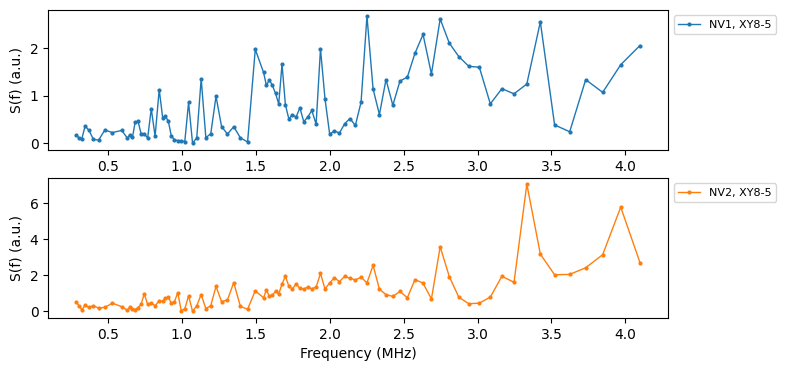

In [42]:
# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(8,4))

# axs[0].plot(x,yNoise, linestyle='-', marker='o', markersize=3, color='C3', label='NV1, XY8-5+noise')
axs[0].plot(x,yOldRR_XY85, linestyle='-', linewidth=1, marker='o', markersize=2, color='C0', label='NV1, XY8-5')
# axs[0].plot(x,(yOldRR-1)*5, linestyle='--', linewidth=1, marker='o', markersize=2, color='C0', label='NV1, XY8-1, scaled 5x')

axs[0].set_title('')
axs[0].set_ylabel('S(f) (a.u.)')
axs[0].legend(fontsize=8,loc='upper left', bbox_to_anchor=(1, 1))
# axs[0].set_yscale('log')

# axs[1].plot(x,yNoise2, linestyle='-', marker='o', markersize=3, color='C2', label='NV2, XY8-5+noise')
axs[1].plot(x,yOldRR_XY852, linestyle='-', linewidth=1, marker='o', markersize=2, color='C1', label='NV2, XY8-5')
# axs[1].plot(x,(yOldRR2-1)*5, linestyle='--', linewidth=1, marker='o', markersize=2, color='C1', label='NV2, XY8-1, scaled 5x')

axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('S(f) (a.u.)')
axs[1].legend(fontsize=8,loc='upper left', bbox_to_anchor=(1, 1))

# axs[1].vlines(x=3, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
# axs[1].vlines(x=1, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
# axs[1].vlines(x=0.6, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
# axs[0].vlines(x=3, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
# axs[0].vlines(x=1, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')
# axs[0].vlines(x=0.6, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='black')

# axs[0].vlines(x=1.94, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')
# axs[1].vlines(x=1.94, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')

# axs[0].vlines(x=2.27, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')
# axs[1].vlines(x=2.27, ymin=min(yNoise2)*5, ymax=max(yNoise2)*1.1, linestyle='--',linewidth=0.5, color='red')

Peaks (kHz) [  49.8  398.   995.  1243.8 1393.  1542.3 1940.3 2437.8 3830.8 3980.1
 4676.6 4825.9]
Peaks (kHz) [49.8]


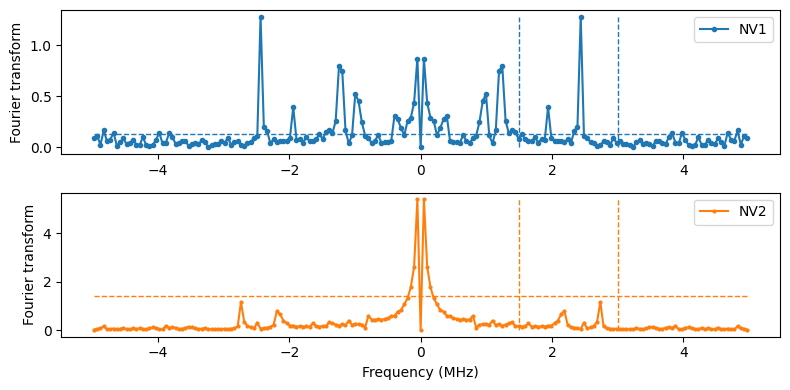

In [47]:
f, yfourier =  fourier(y,  delta_t=100e-9, f_factor=1e6)
f2,yfourier2 = fourier(y2, delta_t=100e-9, f_factor=1e6)

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(8,4))

axs[0].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C0', label='NV1')
axs[0].set_title('')
axs[0].set_ylabel('Fourier transform')
axs[0].legend()
# axs[0].set_ylim((0,5))

axs[1].plot(f2, yfourier2, linestyle='-', marker='o', markersize=2, color='C1', label='NV2')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier transform')
axs[1].legend()
# axs[1].set_ylim((0,1))

threshold = 0.13
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

threshold2 = 1.4
peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print('Peaks (kHz)', np.round(fpeaks2*1e3,1))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1, color='C1')
# for i in range(2):
#     axs[i].set_xlim((-0.1, max(f)*1.02))

for i in ((0.5,1)):
    axs[0].vlines(x=3*i, ymin=min(yfourier),  ymax=max(yfourier),  linestyle='--', linewidth = 1, color='C0')
    axs[1].vlines(x=3*i, ymin=min(yfourier2), ymax=max(yfourier2), linestyle='--', linewidth = 1, color='C1')
    

plt.tight_layout()
plt.show()

In [49]:
# import pandas as pd

# Create a DataFrame and save to CSV
df = pd.DataFrame({'f': f, 'yfourier': yfourier2})
df.to_csv('C:/Users/lukin2dmaterials/data/FFT-T2E-nonoise-NV2.csv', index=False)

# Izn rate

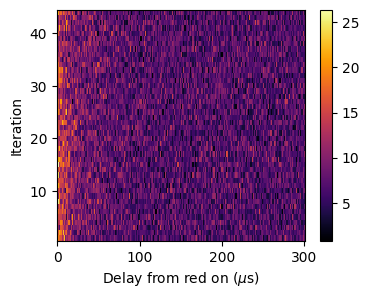

In [1758]:
days = np.linspace(19,19, 1)
dataArr = []; gArr = []; err_gArr = []; cArr = []; err_cArr = []; r0Arr = []; err_r0Arr = []
# fig2, ax2 = plt.subplots()
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'CalibRedRRIonizeRate' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 282 and idx <= 2281:
                read_duration = 250; power = 67; iters = 1e5; power532 = 55; delay1 = 1e3; t532 = 5e3 #durations[idx-7]
                datafile = mainFolder + dataFolder +'/CalibRedRRIonizeRateObject_sig_set.dat'

                x, sig = dr.readDataNoRef(datafile)
                x = np.array(x)/1e3; sig = np.array(sig)
                n = 1
                if len(sig) < n: 
                        print("Bad data: " + datafile)
                else:
                    if math.isnan(sig[-1]): 
                        x = x[0:-1]; sig = sig[0:-1]
                    x = np.linspace(0, x[-1], len(x))
                    xPlot = x
                    y = sig
                    y = y/(read_duration/1e6)
                    y_avg = running_average(y)
                    dataArr.append(y)

                    xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.3,0.03,100))
                    g = 1e3/popt[2]; err_g = 1e3*(perr[2]/popt[2]**2)
                    gArr.append(g); err_gArr.append(err_g)
                    cArr.append(1e3*popt[1]); err_cArr.append(1e3*perr[1])
                    r0Arr.append(yfit[0]*1e3); err_r0Arr.append(1e3*(perr[1]+perr[0]))
                        
dataArr = np.array(dataArr); gArr = np.array(gArr); err_gArr = np.array(err_gArr); 
cArr = np.array(cArr); err_cArr = np.array(err_cArr); r0Arr = np.array(r0Arr); err_r0Arr = np.array(err_r0Arr)

fig, ax = plt.subplots(figsize=(4,3))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel("Delay from red on ($\mu$s)")
ax.set_ylabel(r"Iteration");

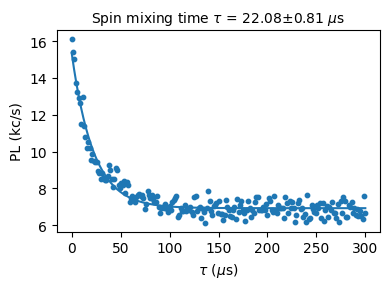

In [1759]:
for idx in np.linspace(0,5,1):
    y = np.average(dataArr, axis=0)
    x = xPlot
    # x = x[1:]
    # y = y[1:]

    fig, ax = plt.subplots(1,1,figsize=(4,3))
    ax.scatter(x,y,s=10 ,label='(sig-ref)/(sig+ref)')
    ax.set_ylabel('PL (kc/s)')
    ax.set_xlabel('$\\tau$ ($\mu$s)')

    guess = (8,0,4)
    xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
    # ax.set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1]))
    ax.set_title('Spin mixing time $\\tau$ = %.2f$\pm$%.2f $\mu$s' % (popt[2],perr[2]), fontsize=10)
    
    ax.plot(xfit,yfit)
    # ax.set_yscale('log')
    

    plt.tight_layout()

## With izn pulse

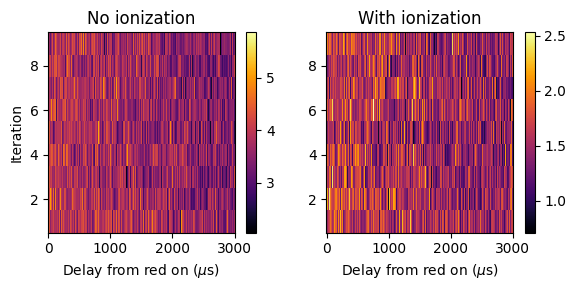

In [1479]:
days = np.linspace(11,11,1)
sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'CalibRedRRIznRateWithIznPulse' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 138 and idx <= 146:
                read_duration = 7500; power = 67; iters = 1e5; power532 = 55; delay1 = 1e3; t532 = 5e3 #durations[idx-7]
                datafile = mainFolder + dataFolder +'/CalibRedRRIznRateWithIznPulseObject_sig_set.dat'

                x, sig, ref = dr.readDataNoPlot(datafile)
                x = np.array(x)/1e3; sig = np.array(sig); ref = np.array(ref)
               
                if math.isnan(sig[-1]): 
                    x = x[0:-1]; sig = sig[0:-1]
                x = np.linspace(0, x[-1], len(x))
                xPlot = x
                sig = sig/(read_duration/1e6); ref = ref/(read_duration/1e6)
                sigArr.append(sig); refArr.append(ref)
        
sigArr = np.array(sigArr); refArr = np.array(refArr)

fig, axs = plt.subplots(1,2,figsize=(6,3))
N_datasets = np.size(sigArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)

plot = axs[0].pcolormesh(X,Y, sigArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax = axs[0]);
axs[0].set_xlabel("Delay from red on ($\mu$s)")
axs[0].set_ylabel(r"Iteration");
axs[0].set_title('No ionization');

plot = axs[1].pcolormesh(X,Y, refArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax = axs[1]);
axs[1].set_xlabel("Delay from red on ($\mu$s)")
axs[1].set_title('With ionization');

plt.tight_layout()

In [1478]:
yold=y

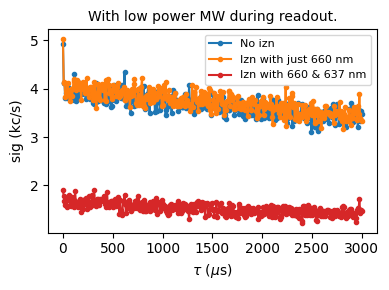

In [1481]:
ifPlotTogether = 1
for idx in np.linspace(0,5,1):
    y = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot
    if ifPlotTogether:
        fig, ax = plt.subplots(figsize=(4,3))
        ax.plot(x,y, 'o-', color='C0', markersize=3, label='No izn')
        ax.set_ylabel('sig (kc/s)')
        ax.set_xlabel('$\\tau$ ($\mu$s)')
        ax.legend()

        guess = (6,6,150)
        xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
        s1 = 'No izn: $\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1])
        s1 = 'With izn: $C_{avg}$ = %.2f' % np.average(y)
        # ax.plot(xfit,yfit,color='C0')
        # ax.set_yscale('log')

        ax.plot(x,yold, 'o-', color='C1',markersize=3, label='Izn with just 660 nm')
        ax.set_xlabel('$\\tau$ ($\mu$s)')
        ax.legend()

        ax.plot(x,yr, 'o-', color='C3',markersize=3, label='Izn with 660 & 637 nm')
        ax.set_xlabel('$\\tau$ ($\mu$s)')
        ax.legend(fontsize=8)

        guess = (1,1,150)
        xfit, yfit, popt, perr = dr.fitDecay(x,yr, guess=guess)
        s2 = 'With izn: $\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1])
        s2 = 'With izn: $C_{avg}$ = %.2f' % np.average(yr)
        # ax.set_title(s1 + "\n" + s2,fontsize=8)
        ax.set_title('With low power MW during readout.',fontsize=10)
        # ax.plot(xfit,yfit,color='C3')
    else:
        fig, axs = plt.subplots(1,2,figsize=(8,3))
        axs[0].plot(x,y, 'o-', markersize=3, label='No izn')
        axs[0].set_ylabel('sig (kc/s)')
        axs[0].set_xlabel('$\\tau$ ($\mu$s)')
        axs[0].legend()

        guess = (8,0,4)
        xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
        axs[0].set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1]))
        axs[0].plot(xfit,yfit)
        # axs[0].set_yscale('log')

        axs[1].plot(x,yr, 'o-', markersize=3, label='With izn')
        axs[1].set_xlabel('$\\tau$ ($\mu$s)')
        axs[1].legend()

        guess = (8,0,4)
        xfit, yfit, popt, perr = dr.fitDecay(x,yr, guess=guess)
        axs[1].set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1]))
        axs[1].plot(xfit,yfit)
        # axs[0].set_yscale('log')
        

    plt.tight_layout()

# Sat curve: for each current, sweep some vpz

In [ ]:
# ODMR
days = np.linspace(3,3,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (day==1 and idx >= 51) or (day==2 and idx <= 112):
            if (day==3 and idx >= 1558 and idx <= 1578):
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)

Iarray = np.linspace(46,48,21)
# Iarray = np.linspace(46.5,50,36)
y = Iarray[0:N_datasets]

X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Current (mA)')
axs[0].set_title('Panel b minus panel c',fontsize=10)
# axs[0].set_ylim((100,200))

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('Vpiezo (%)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

In [ ]:
y = np.max(refArr,axis=1)
x = Iarray[0:len(y)]

fig, axs = plt.subplots(2,1,figsize=(12,6)) #
axs[0].plot(x,y, 'o-', markersize=3, linewidth = 1)
axs[0].set_ylabel('Max count of ms=0 init-ed peak')
axs[0].set_title("Center wavlength = 637.23 nm")

y1 = np.abs(np.min(dataArr,axis=1))
axs[1].plot(x,y1, 'o-', markersize=3, linewidth = 1, color='C1')
axs[1].set_xlabel('Current (mA)')
axs[1].set_ylabel('Max contrast')

plt.tight_layout()

# SCC + RR: Photon Statistics

In [149]:
# Repeat measuring SCC photon stats
days = np.linspace(28,28,1)
wanted_idx = 104
dataArr = []; gArr = []; err_gArr = []; sigs = None; refs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'SCCRRPhotonStatIrber' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx == wanted_idx:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/SCCRRPhotonStatIrberObject_sig_set.dat'
                power589 = 0; power532 = 400; power635 = 40
                t532=1e6; delay1=1.1e3; delay2=100; tsh=100; delay3=50; ti=-1; delay4=2e6; tr_ns=2e6
                delay_between_MWmix = 5e3
                
                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)
                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if refs is None: refs = ref
                else: refs = np.concatenate((refs, ref),axis=1)
print(np.shape(sigs))
sweepWhat = 'ti'

tis = np.array((5e4, 2e4, 7000,5500,4800,4200,3600,3000,2400,1600))  # sweep ti
tis = np.array((9000,7000))#,5500,4800,4200,3600,3000))#,1500)) # sweep ti
tis = np.array((15e3, 12e3, 10.5e3, 9000, 7500,6000,4500,3000))
# tis = np.array((1,5,10,30,50,75,100)) # sweep nSpinInit

(8, 1500)


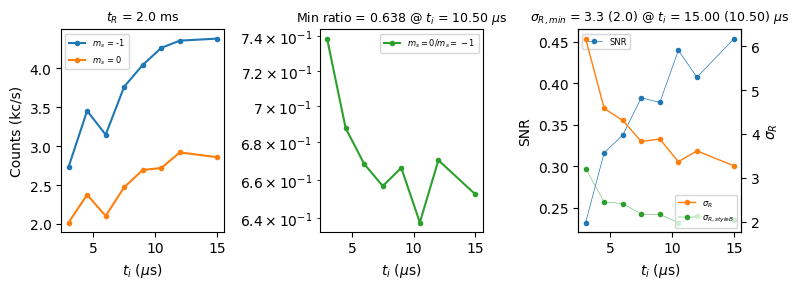

In [150]:
sigs_avg = np.average(sigs,axis=1)/(tr_ns/1e6); sigs_avg_count = np.average(sigs,axis=1)
refs_avg = np.average(refs,axis=1)/(tr_ns/1e6); refs_avg_count = np.average(refs,axis=1)
x = tis/1e3; fontsize=6

fig, axs = plt.subplots(1,3,figsize=(8,3))
axs[0].plot(x,sigs_avg,'o-', label="$m_s$ = -1",markersize=3)
axs[0].plot(x,refs_avg,'o-', label="$m_s$ = 0",markersize=3)
axs[0].legend(fontsize=fontsize)
axs[0].set_xlabel('$t_i$ ($\mu$s)')
axs[0].set_ylabel('Counts (kc/s)')
axs[0].set_title('$t_R$ = %.1f ms' % (tr_ns/1e6), fontsize=fontsize+3)
# axs[0].set_title('delay_between_MWmix = %.1f $\mu$s' % (delay_between_MWmix/1e3), fontsize=10)
# axs[0].set_xscale('log')

y = refs_avg/sigs_avg
axs[1].plot(x,y,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
axs[1].legend(fontsize=fontsize)
axs[1].set_xlabel('$t_i$ ($\mu$s)')
# axs[1].set_xscale('log')
axs[1].set_title('Min ratio = %.3f @ $t_i$ = %.2f $\mu$s' % (np.min(y), x[np.argmin(y)]), fontsize=fontsize+3)

###########################################
sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
snr =        (sigs_avg_count-refs_avg_count)/np.sqrt(sigma_sig**2 + sigma_ref**2)
snr_styleB = (sigs_avg_count-refs_avg_count)/np.sqrt(sigs_avg_count + refs_avg_count)
sigmaR = np.sqrt(1+2/snr**2); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

axs[2].plot(x, snr, 'o-', linewidth=0.5, markersize=3, label="SNR")
# axs[2].set_xscale('log')
axs[2].legend(loc='upper left',fontsize=fontsize)
axs[2].set_xlabel('$t_i$ ($\mu$s)')
axs[2].set_ylabel('SNR')
axs[2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ $t_i$ = %.2f (%.2f) $\mu$s' 
                 % (np.min(sigmaR), np.min(sigmaR_styleB), 
                    x[np.argmin(sigmaR)],x[np.argmin(sigmaR_styleB)]), fontsize=fontsize+3)

ax=axs[2].twinx()
ax.plot(x, sigmaR,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
ax.plot(x, sigmaR_styleB,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
# ax.set_xscale('log')
axs[1].set_yscale('log')
# ax.set_ylim((2,30))
ax.legend(loc='lower right',fontsize=fontsize)
ax.set_xlabel('$t_i$ ($\mu$s)')
ax.set_ylabel('$\sigma_R$')

plt.tight_layout()
plt.show()

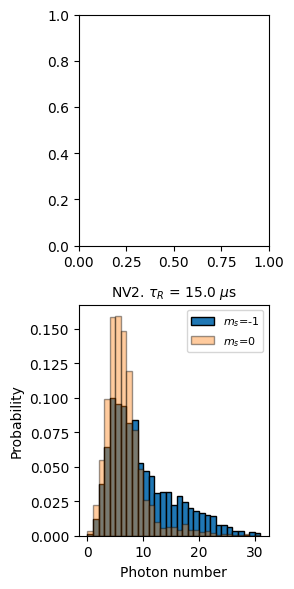

In [2795]:
i=0
fig,axs = plt.subplots(2,1,figsize=(3,6))

# hist, bins = np.histogram(sigs[i],bins=np.arange(np.max(sigs[i])+1))
# axs[0].hist(sigs[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
# axs[0].hist(refs[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# # axs[0].set_yscale('log')
# axs[0].legend(fontsize=8)
# s = r"NV1. $\tau_R$ = %.1f $\mu$s" % (x[i])
# axs[0].set_title(s, fontsize=10)
# axs[0].set_ylabel('Probability')
# # axs[0].set_xlabel('Photon number')

hist, bins = np.histogram(sigs[i],bins=np.arange(np.max(sigs[i])+1))
axs[1].hist(sigs[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[1].hist(refs[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[1].set_yscale('log')
axs[1].legend(fontsize=8)
s = r"NV2. $\tau_R$ = %.1f $\mu$s" % (x[i])
axs[1].set_title(s, fontsize=10)
axs[1].set_xlabel('Photon number')
axs[1].set_ylabel('Probability')

plt.tight_layout()

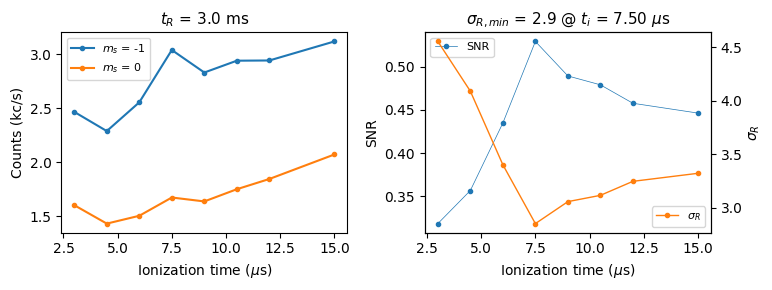

In [2796]:
sigs_avg = np.average(sigs,axis=1)/(tr_ns/1e6); sigs_avg_count = np.average(sigs,axis=1)
refs_avg = np.average(refs,axis=1)/(tr_ns/1e6); refs_avg_count = np.average(refs,axis=1)
x = tis/1e3; fontsize=8

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(x,sigs_avg,'o-', label="$m_s$ = -1",markersize=3)
axs[0].plot(x,refs_avg,'o-', label="$m_s$ = 0",markersize=3)
axs[0].legend(fontsize=fontsize)
axs[0].set_xlabel('Ionization time ($\mu$s)')
axs[0].set_ylabel('Counts (kc/s)')
axs[0].set_title('$t_R$ = %.1f ms' % (tr_ns/1e6), fontsize=fontsize+3)

###########################################
sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
snr =        (sigs_avg_count-refs_avg_count)/np.sqrt(sigma_sig**2 + sigma_ref**2)
snr_styleB = (sigs_avg_count-refs_avg_count)/np.sqrt(sigs_avg_count + refs_avg_count)
sigmaR = np.sqrt(1+2/snr**2); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

axs[1].plot(x, snr, 'o-', linewidth=0.5, markersize=3, label="SNR")
# axs[2].set_xscale('log')
axs[1].legend(loc='upper left',fontsize=fontsize)
axs[1].set_ylabel('SNR')
axs[1].set_xlabel('Ionization time ($\mu$s)')
axs[1].set_title('$\sigma_{R,min}$ = %.1f @ $t_i$ = %.2f $\mu$s' 
                 % (np.min(sigmaR), 
                    x[np.argmin(sigmaR)]), fontsize=fontsize+3)

ax=axs[1].twinx()
ax.plot(x, sigmaR,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
# ax.plot(x, sigmaR_styleB,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')

ax.legend(loc='lower right',fontsize=fontsize)
ax.set_xlabel('$t_i$ ($\mu$s)')
ax.set_ylabel('$\sigma_R$')

plt.tight_layout()
plt.show()

In [ ]:
ifPlot=1

ms = -1
ths, fids, pms, snrs, gms, g0s, nms, n0s, nMeanms, nMean0s = dr.plotHistSweepTIon(sigs, tis, sweepWhat=sweepWhat, 
                ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
                t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
                gm=1e3,g0=1e3,nm=1e3,n0=1e3, ifLogPlot=1)

ms = 0
thsref, fidsref, pmsref, snrsref, gmsref, g0sref, nmsref, n0sref, nMeanmsref, nMean0sref = dr.plotHistSweepTIon(refs, tis, sweepWhat=sweepWhat, 
                ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
                t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
                gm=1e5,g0=1e5,nm=1e5,n0=1e5, ifLogPlot=1)

# dr.plotHistSweepTIonNoFit(sigs, tis, sweepWhat=sweepWhat, 
#                 ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
#                 t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
#                 gm=1e6,g0=1e6,nm=1e6,n0=1e5, ifLogPlot=1)

# ms = 0
# dr.plotHistSweepTIonNoFit(refs, tis, sweepWhat=sweepWhat, 
#                 ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
#                 t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
#                 gm=1e5,g0=1e5,nm=1e5,n0=1e5, ifLogPlot=1)

In [ ]:
tis, ths, fids, pms, snrs, gms, g0s, nms, n0s, nMeanms, nMean0s, thsref, fidsref, pmsref, snrsref, gmsref, g0sref, nmsref, n0sref, nMeanmsref, nMean0sref, sigmaSCC = dr.plotAnalysisSweepTIon(finalDataFolder, 
                sweepWhat=sweepWhat, power589=power589, power532=power532, power635=power635,
                t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns,
                ifYlim=1, ylim=(4,40))
n1s = nMeanms*pms + nMean0s*(1-pms)
n0s = nMeanmsref*pmsref + nMean0sref*(1-pmsref)
snr = (n1s-n0s)/np.sqrt(n1s+n0s)
sigmaUnThres = np.sqrt(1 + 2/snr**2)

# T1 SCC RR one NV

In [ ]:
# Repeat measuring T1 SCC
days = np.linspace(11,15,5)
wanted_idx = 6
dataArr = []; gArr = []; err_gArr = []; sigs = None; refs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T1SCCRRIrber' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx == wanted_idx:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/T1SCCRRIrberObject_sig_set.dat'
                power635 = 280; power532 = 2400; power660 = 15
                ti = 4800; tr_ns = 2e6

                taus, sig, ref = dr.readDataFullDataDualNVSingleRead(datafile)
            
                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if refs is None: refs = ref
                else: refs = np.concatenate((refs, ref),axis=1)

print(np.shape(sigs))
sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
                

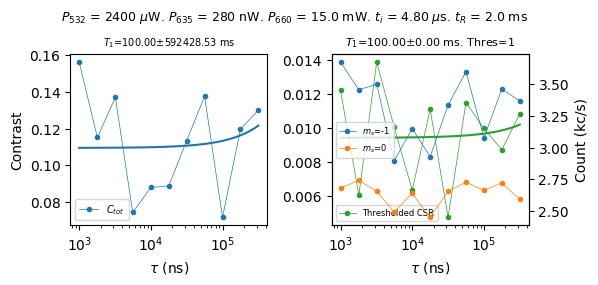

In [1087]:
t1s, t1s_err = dr.plotT1Simple(taus, sigs, refs, thresmax=6, power660=power660, power532=power532, power635=power635,
                ti=ti, tr_ns=tr_ns)

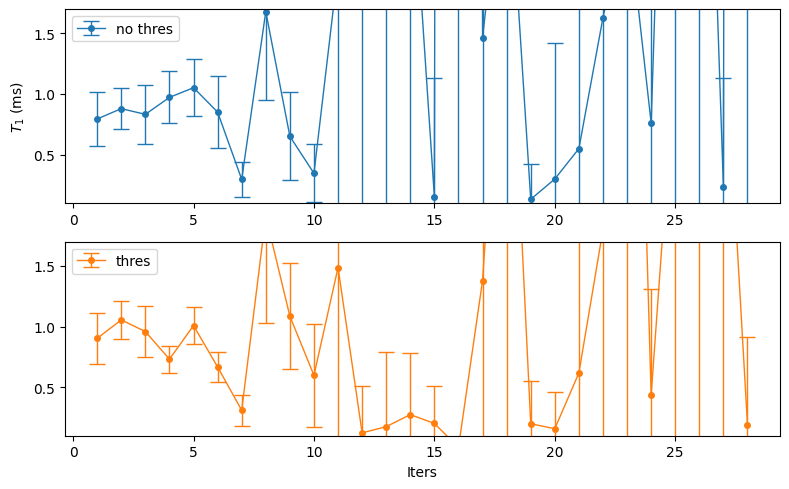

In [5]:
# Repeat measuring T1 SCC
days = np.linspace(12,12,1)
dataArr = []; gArr = []; err_gArr = []; t1sArr = []; t1s_errArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-12-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T1SCCRRIrber' in dataFolder:
            idx = int(dataFolder[1:4])
            if (idx >= 24 and idx <= 79) and np.mod(idx,2)==1:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/T1SCCRRIrberObject_sig_set.dat'
                power635 = 65; power532 = 350; power660 = 15
                ti=2500; tr_ns = 1e6

                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)

                # if idx <= 61: taus = np.round(np.logspace(3,np.log10(5e6),21),-2)
                # elif idx <= 64: taus = np.round(np.logspace(3,np.log10(10e6),21),-2)
                taus = np.round(np.logspace(3,np.log10(10e6),21),-2)

                t1s, t1s_err = dr.plotT1Simple(taus, sig, ref, thresmax=5, power660=power660, power532=power532, power635=power635,
                                                ti=ti, tr_ns=tr_ns,ifPlot=0)
                t1sArr.append(t1s); t1s_errArr.append(t1s_err)

t1sArr = np.array(t1sArr); t1s_errArr = np.array(t1s_errArr)

fig, axs = plt.subplots(2,1, figsize=(8,5))
y1 = t1sArr[:,0]; y2=t1sArr[:,1]
x = np.linspace(1,len(y1),len(y1))
axs[0].errorbar(x,y1, t1s_errArr[:,0], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6, label=('no thres'))
# axs[0].set_xlabel("Iters")
axs[0].set_ylabel("$T_1$ (ms)")
axs[0].legend()
axs[0].set_ylim((0.1,1.7))

axs[1].errorbar(x,y2, t1s_errArr[:,1], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6,color='C1',label=('thres'))
axs[1].set_xlabel("Iters")
axs[1].legend()
axs[1].set_ylim((0.1,1.7))

plt.tight_layout()
plt.show()

# T1 SCC RR Dual NV

In [244]:
# Repeat measuring T1 SCC
days = np.linspace(11,28,18); a = 'T1SCCRRIrberDualNV'; b = 'T1RRDualNV'
sigs = None; refs = None; sigs2 = None; refs2 = None; type = a
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            # if day == 16 and (idx >= 0 and idx <= 3):
            # if (day == 26) or (day==27 and idx <= 43):
            if (day==27 and idx >= 44) or day==28:
            # if (day==28 and idx ==16):
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/' + type + 'Object_sig_set.dat'
                ti = 4200; tr_ns = 2e6

                taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
            
                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if refs is None: refs = ref
                else: refs = np.concatenate((refs, ref),axis=1)
                if sigs2 is None: sigs2 = sig2
                else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                if refs2 is None: refs2 = ref2
                else: refs2 = np.concatenate((refs2, ref2),axis=1)

print(np.shape(sigs))
                

(21, 36000)


In [245]:
thres = 12
# sigs = thresholded(sigs,thres); refs = thresholded(refs,thres)
# sigs2 = thresholded(sigs2, thres); refs2 = thresholded(refs2, thres)

sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

# contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
# contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

contrast = contrast_new(sigs,refs,sigavg,refavg); contrast2 = contrast_new(sigs2, refs2,sigavg2,refavg2)
contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

covSig = cov(sigs,sigs2); covRef = cov(refs, refs2)
covContrast = cov(contrast, contrast2)

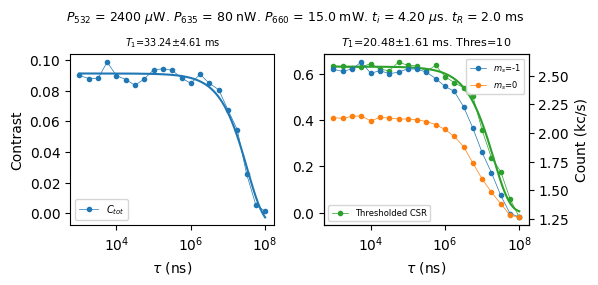

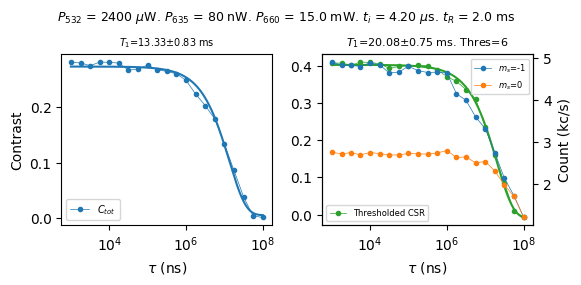

In [246]:
t1s, t1s_err = dr.plotT1Simple(taus, sigs, refs, ifThres=1, thres=thres, thresmax=10, ifContrastFirstThenAvg=0,
                               power660=15, power532=2400, power635=80, ti=ti, tr_ns=tr_ns)
t1s2, t1s_err2 = dr.plotT1Simple(taus, sigs2, refs2, ifThres=1, thres=thres, thresmax=10, ifContrastFirstThenAvg=0,
                               power660=15, power532=2400, power635=80, ti=ti, tr_ns=tr_ns)

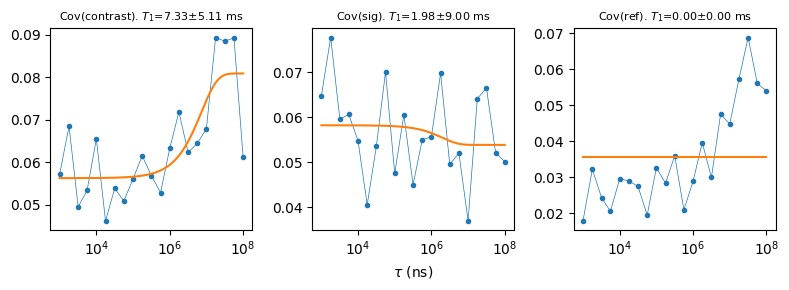

In [247]:
fig, axs = plt.subplots(1,3,figsize=(8,3))

axs[0].plot(taus, covContrast, 'o-', linewidth=0.5, markersize=3, label="covRef")
xfit, yfit, popt, perr = dr.fitDecay(taus,covContrast,guess=(0.03,0,1e6))
axs[0].plot(xfit,yfit)
s = "Cov(contrast). $T_{1}$=%.2f$\pm$%.2f ms" % (popt[2]/1e6, perr[2]/1e6)
axs[0].set_title(s, fontsize=8)
axs[0].set_xscale('log')


axs[1].plot(taus, covSig, 'o-', linewidth=0.5, markersize=3, label="covSig")
xfit, yfit, popt, perr = dr.fitDecay(taus,covSig,guess=(0.03,0,1e6))
axs[1].plot(xfit,yfit)
s = "Cov(sig). $T_{1}$=%.2f$\pm$%.2f ms" % (popt[2]/1e6, perr[2]/1e6)
axs[1].set_title(s, fontsize=8)
axs[1].set_xscale('log')
axs[1].set_xlabel('$\\tau$ (ns)')

axs[2].plot(taus, covRef, 'o-', linewidth=0.5, markersize=3, label="covRef")
xfit, yfit, popt, perr = dr.fitDecay(taus,covRef,guess=(0.03,0,1e6))
axs[2].plot(xfit,yfit)
s = "Cov(ref). $T_{1}$=%.2f$\pm$%.2f ms" % (popt[2]/1e6, perr[2]/1e6)
axs[2].set_title(s, fontsize=8)
axs[2].set_xscale('log')

plt.tight_layout()
plt.show()

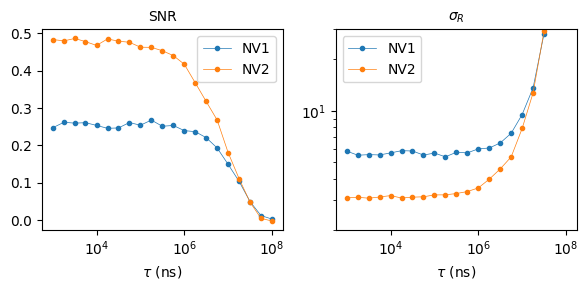

In [3260]:
fig, axs = plt.subplots(1,2,figsize=(6,3))

axs[0].plot(taus, snr_styleA, 'o-', linewidth=0.5, markersize=3, label="NV1")
axs[0].plot(taus, snr_styleA2, 'o-', linewidth=0.5, markersize=3, label="NV2")
s = "SNR"
axs[0].set_title(s, fontsize=10)
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('$\\tau$ (ns)')

axs[1].plot(taus, sigmaR_styleA,  'o-', linewidth=0.5, markersize=3, label="NV1")
axs[1].plot(taus, sigmaR_styleA2, 'o-', linewidth=0.5, markersize=3, label="NV2")
s = "$\sigma_R$"
axs[1].set_title(s, fontsize=10)
axs[1].set_xscale('log'); axs[1].set_yscale('log')
axs[1].set_ylim((2,30))
axs[1].legend()
axs[1].set_xlabel('$\\tau$ (ns)')

plt.tight_layout()
plt.show()

### Histogram

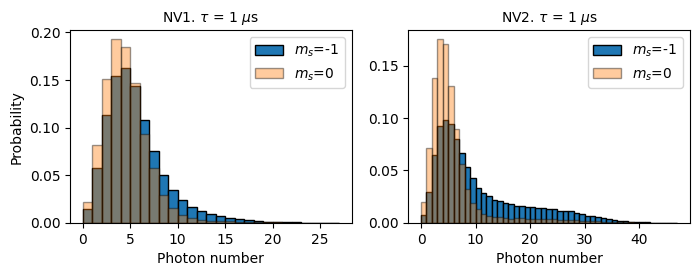

In [3262]:
i=0
fig,axs = plt.subplots(1,2,figsize=(8,2.5))

hist, bins = np.histogram(sigs[i],bins=np.arange(np.max(sigs[i])+1))
axs[0].hist(sigs[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[0].hist(refs[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[0].set_yscale('log')
axs[0].legend()
s = r"NV1. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
axs[0].set_title(s, fontsize=10)
axs[0].set_ylabel('Probability')
axs[0].set_xlabel('Photon number')

hist, bins = np.histogram(sigs2[i],bins=np.arange(np.max(sigs2[i])+1))
axs[1].hist(sigs2[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[1].hist(refs2[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[1].set_yscale('log')
axs[1].legend()
s = r"NV2. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
axs[1].set_title(s, fontsize=10)
axs[1].set_xlabel('Photon number')

plt.show()

### Repeat measuring T1 SCC

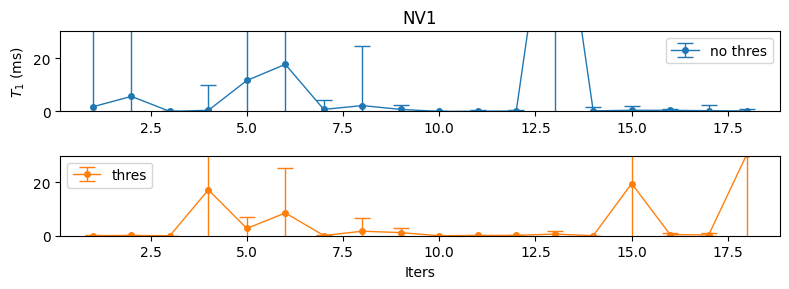

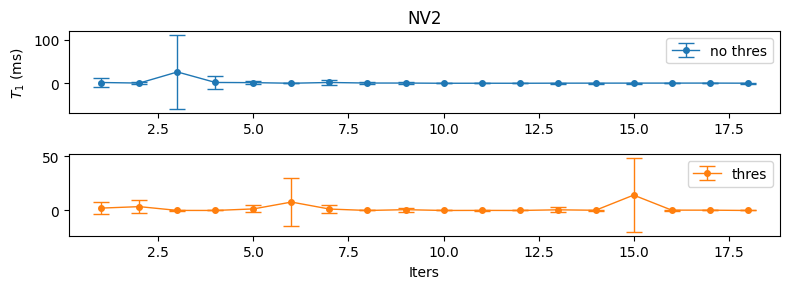

In [3267]:
days = np.linspace(27,27,1)
t1sArr = []; t1s_errArr = []; t1sArr2 = []; t1s_errArr2 = []; covContrastAvg_Arr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T1SCCRRIrberDualNV' in dataFolder:
            idx = int(dataFolder[1:4])
            if (idx >= -70 and idx <= 43) and np.mod(idx,1)==0:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/T1SCCRRIrberDualNVObject_sig_set.dat'
                power635 = 65; power532 = 350; power660 = 15
                ti=4000; tr_ns = 2e6

                taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                # taus = np.round(np.logspace(3,np.log10(10e6),21),-2)
                taus = np.round(np.logspace(3,np.log10(100e6),21),-2)

                t1s, t1s_err = dr.plotT1Simple(taus, sig, ref, thresmax=10, power660=power660, power532=power532, power635=power635,
                                                ti=ti, tr_ns=tr_ns,ifPlot=0)
                t1sArr.append(t1s); t1s_errArr.append(t1s_err)
                t1s2, t1s_err2 = dr.plotT1Simple(taus, sig2, ref2, thresmax=10, power660=power660, power532=power532, power635=power635,
                                                ti=ti, tr_ns=tr_ns,ifPlot=0)
                t1sArr2.append(t1s2); t1s_errArr2.append(t1s_err2)

                sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
                sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)


                contrast = contrast_new(sig,ref,sigavg,refavg); contrast2 = contrast_new(sig2, ref2,sigavg2,refavg2)
                contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

                covSig = cov(sigs,sigs2); covRef = cov(refs, refs2)
                covContrast = cov(contrast, contrast2)
                covContrastAvg_Arr.append(np.average(covContrast))

t1sArr = np.array(t1sArr); t1s_errArr = np.array(t1s_errArr)
t1sArr2 = np.array(t1sArr2); t1s_errArr2 = np.array(t1s_errArr2)
covContrastAvg_Arr = np.array(covContrastAvg_Arr)

fig, axs = plt.subplots(2,1, figsize=(8,3))
y1 = t1sArr[:,0]; y2=t1sArr[:,1]
x = np.linspace(1,len(y1),len(y1))
axs[0].errorbar(x,y1, t1s_errArr[:,0], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6, label=('no thres'))
axs[0].set_title("NV1")
axs[0].set_ylabel("$T_1$ (ms)")
axs[0].legend()
axs[0].set_ylim((0,30))

axs[1].errorbar(x,y2, t1s_errArr[:,1], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6,color='C1',label=('thres'))
axs[1].set_xlabel("Iters")
axs[1].legend()
axs[1].set_ylim((0,30))

plt.tight_layout()
plt.show()
#######################################################
fig, axs = plt.subplots(2,1, figsize=(8,3))
y1 = t1sArr2[:,0]; y2=t1sArr2[:,1]
x = np.linspace(1,len(y1),len(y1))
axs[0].errorbar(x,y1, t1s_errArr2[:,0], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6, label=('no thres'))
axs[0].set_title("NV2")
axs[0].set_ylabel("$T_1$ (ms)")
axs[0].legend()

axs[1].errorbar(x,y2, t1s_errArr2[:,1], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6,color='C1',label=('thres'))
axs[1].set_xlabel("Iters")
axs[1].legend()

plt.tight_layout()
plt.show()

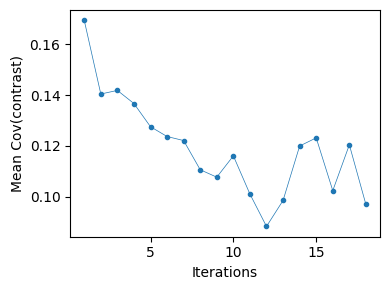

In [202]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(x, covContrastAvg_Arr, 'o-', linewidth=0.5, markersize=3, )
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean Cov(contrast)")

plt.tight_layout()
plt.show()

# T1 RR

In [1051]:
# T1 RR
days = np.linspace(11,15,5)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T1RRDualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if day == 14 and idx >= 35 and idx <= 40:
            # if (day == 14 and idx >= 177) or (day==15 and idx>=-9 and idx <= 10):
            if (day == 15 and idx >= 172 and idx <= 185):
                datafile = mainFolder + dataFolder +'/T1RRDualNVObject_sig_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

(14, 21)


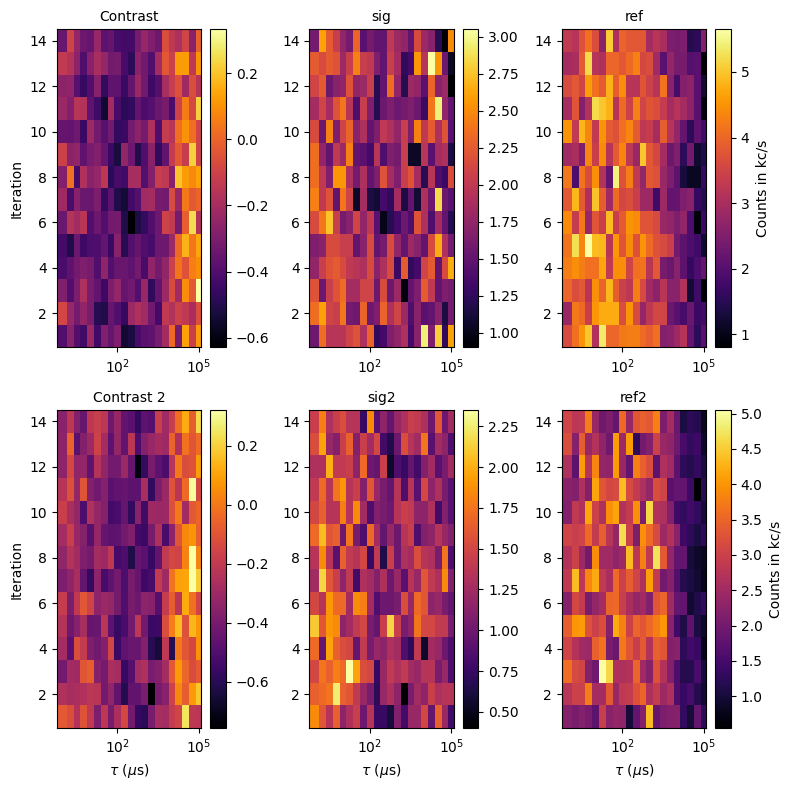

In [1052]:
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
nan_indices = np.isnan(data2Arr)
data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('Contrast',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('Contrast 2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

for i in ((0,1)):
    for j in ((0,1,2)):
        axs[i,j].set_xscale('log')

plt.tight_layout()


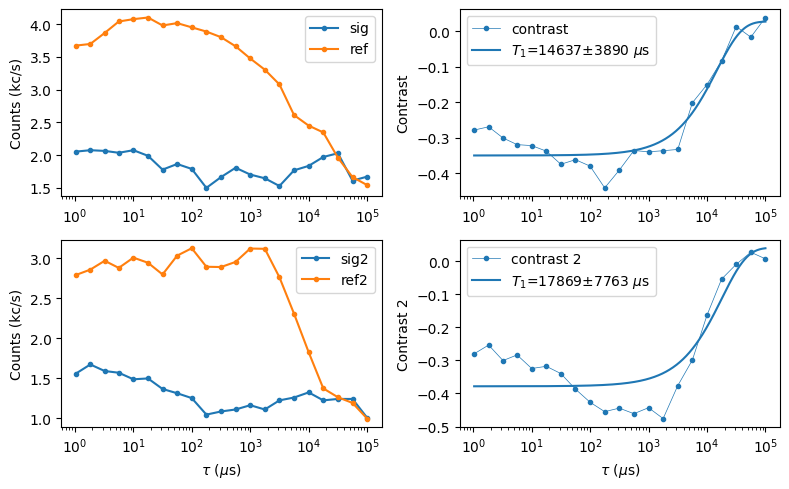

In [1053]:
ifXAxisFreq = 0; correctionToTau = 40; markerAt = 3

x = (xPlot+correctionToTau)/1e3
if ifXAxisFreq: x = 1/(2*(xPlot+correctionToTau)*1e-3)

y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

fig, axs = plt.subplots(2,2,figsize=(8,5))
axs[0,1].plot(x,y, 'o-', markersize=3, linewidth=0.5,label="contrast")
axs[0,1].set_ylabel('Contrast')
# axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--',linewidth=1)

a = np.max(y)
guess = (a,0,1e6)
xfit, yfit, popt, perr = dr.fitDecay(x,y,guess=guess)
s = "$T_{1}$=%.0f$\pm$%.0f $\mu$s" % (popt[2], perr[2])
axs[0,1].plot(xfit, yfit, label=s, color='C0')

axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
axs[0,0].set_ylabel('Counts (kc/s)')

################################################################################
axs[1,1].plot(x,y2, 'o-', markersize=3, linewidth=0.5,label="contrast 2")
axs[1,1].set_ylabel('Contrast 2')
axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
# axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--',linewidth=1)
if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")

a2 = np.max(y2)
guess = (a2,0,1e6)
xfit, yfit, popt, perr = dr.fitDecay(x,y2,guess=guess)
s = "$T_{1}$=%.0f$\pm$%.0f $\mu$s" % (popt[2], perr[2])
axs[1,1].plot(xfit, yfit, label=s, color='C0')

axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig2")
axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref2")
axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
axs[1,0].set_ylabel('Counts (kc/s)')

for i in ((0,1)):
    for j in ((0,1)):
        axs[i,j].set_xscale('log')
        axs[i,j].legend()

plt.tight_layout()

# T2E/XY8 SCC RR Dual NV

In [ ]:
# Testing smoothing
a = np.linspace(1,2000,2000); x=a
# a=a**2 + 1e5*np.random.normal(size=2000)
f0 = 0.05
a = x**2 + 1e5*np.sin(2*pi*f0*x)
y = subtractMeanFewReps(a,5)

n = 155
z = smooth(a,n)
z1 = smoothConvolution(a,n)

fig, ax = plt.subplots(figsize=(12,3))
# ax.plot(x,a)
# ax.plot(x,y)
ax.plot(x,a-z)
# ax.plot(x,a-z1)
# ax.set_yscale('log')
# ax.plot(range(len(z)),z)
# ax.set_xlim((1990,2000))
# ax.set_ylim((-10e4,10e4))

###########################################################################################
y = a-z1
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 1) # insert spacing

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

fig,ax=plt.subplots(figsize=(6,3))
ax.plot(f,yfourier)

peaks = find_peaks(yfourier,threshold=5e7)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (detuning from f0)', fpeaks-f0)

In [1396]:
# Repeat measuring T2E/XY8
days = np.linspace(2,3,2)
sigs = None; refs = None; sigs2 = None; refs2 = None; type='T2E'
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNV'; name2 = '/T2ESCCRRIrberDualNVObject_sig_set.dat'
elif type == 'XY8':
    name1 = 'XY8SCCRRIrberDualNV'; name2 = '/XY8SCCRRIrberDualNVObject_sig_set.dat'
else:
    name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if name1 in dataFolder:
            idx = int(dataFolder[1:4])
            # if (day==25 and idx >= 35 and idx <= 95) or (day==8 and idx<=50):
            if day == 2 and idx == 106 or day == 93:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder + name2
                ti = 2700; tr_ns = 1e6

                if type == 'XY8':
                    taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                else:
                    taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if refs is None: refs = ref
                else: refs = np.concatenate((refs, ref),axis=1)
                if sigs2 is None: sigs2 = sig2
                else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                if refs2 is None: refs2 = ref2
                else: refs2 = np.concatenate((refs2, ref2),axis=1)

print(np.shape(sigs))         

(61, 2000)


In [1397]:
thres = 12
# sigs = thresholded(sigs,thres); refs = thresholded(refs,thres)
# sigs2 = thresholded(sigs2, thres); refs2 = thresholded(refs2, thres)

sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

# contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
# contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

contrast = contrast_new(sigs,refs,sigavg,refavg); contrast2 = contrast_new(sigs2, refs2,sigavg2,refavg2)
contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

covSig = cov(sigs,sigs2); covRef = cov(refs, refs2)
covContrast = cov(contrast, contrast2)  

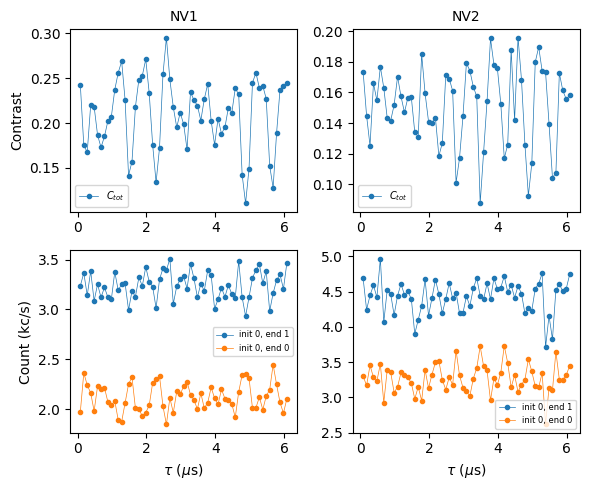

In [1398]:
###### Check the legend before saving image ##########################################
x = taus/1e3
y = (sigavg-refavg)/(sigavg+refavg); y2 = (sigavg2-refavg2)/(sigavg2+refavg2)

fig, axs = plt.subplots(2,2, figsize=(6,5))
a00 = axs[0,0]; a10 = axs[1,0]; a01 = axs[0,1]; a11 = axs[1,1]

a00.plot(x,y, 'o-', linewidth=0.5, markersize=3, label="$C_{tot}$", color='C0')
a00.set_ylabel("Contrast")
a00.legend(fontsize=7, loc='lower left')
a00.set_title('NV1', fontsize=10)

a10.plot(x, sigavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="init 0, end 1")
a10.plot(x, refavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="init 0, end 0")
a10.legend(fontsize=6)
a10.set_ylabel('Count (kc/s)')
a10.set_xlabel("$\\tau$ ($\mu$s)")

a01.plot(x,y2, 'o-', linewidth=0.5, markersize=3, label="$C_{tot}$", color='C0')
a01.legend(fontsize=7, loc='lower left')
a01.set_title('NV2', fontsize=10)

a11.plot(x, sigavg2/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="init 0, end 1")
a11.plot(x, refavg2/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="init 0, end 0")
a11.legend(fontsize=6)
a11.set_xlabel("$\\tau$ ($\mu$s)")

# a00.set_xlim((-0.1,0.6))
# a01.set_xlim((-0.1,1.1))

plt.tight_layout()
plt.show()

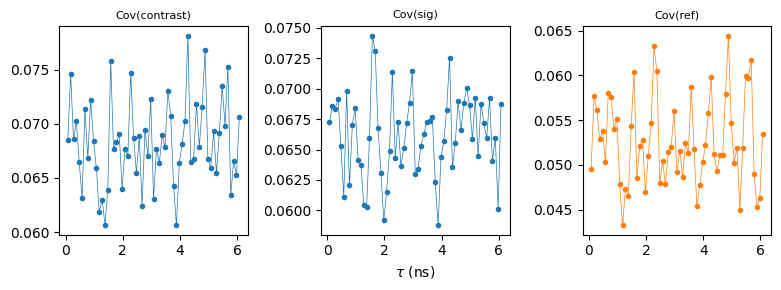

In [657]:
fig, axs = plt.subplots(1,3,figsize=(8,3))

axs[0].plot(x, covContrast, 'o-', linewidth=0.5, markersize=3, label="covRef")
s = "Cov(contrast)"
axs[0].set_title(s, fontsize=8)
# axs[0].set_xlim((0,1.2))

axs[1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="covSig")
s = "Cov(sig)"
axs[1].set_title(s, fontsize=8)
axs[1].set_xlabel('$\\tau$ (ns)')

axs[2].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="covRef", color='C1')
s = "Cov(ref)"
axs[2].set_title(s, fontsize=8)

plt.tight_layout()
plt.show()

In [411]:
navg = 3

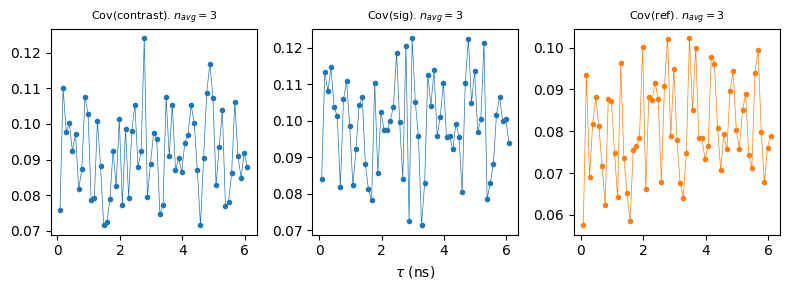

In [412]:
sigsNew = np.zeros(np.shape(sigs)); refsNew = np.zeros(np.shape(sigs))
sigsNew2 = np.zeros(np.shape(sigs)); refsNew2 = np.zeros(np.shape(sigs))

for i in range(len(sig)):
    # sigsNew[i] = subtractMeanFewReps(sigs[i],navg); sigsNew2[i] = subtractMeanFewReps(sigs2[i],navg)
    # refsNew[i] = subtractMeanFewReps(refs[i],navg); refsNew2[i] = subtractMeanFewReps(refs2[i],navg)

    # sigsNew[i] = smoothConvolution(sigs[i],navg); sigsNew2[i] = smoothConvolution(sigs2[i],navg)
    # refsNew[i] = smoothConvolution(refs[i],navg); refsNew2[i] = smoothConvolution(refs2[i],navg)

    sigsNew[i] = sigs[i]-smoothConvolution(sigs[i],navg); sigsNew2[i] = sigs2[i]-smoothConvolution(sigs2[i],navg)
    refsNew[i] = refs[i]-smoothConvolution(refs[i],navg); refsNew2[i] = refs2[i]-smoothConvolution(refs2[i],navg)

covSigNew = cov(sigsNew,sigsNew2); covRefNew = cov(refsNew, refsNew2)
contrastNew = contrast_new(sigsNew,refsNew,sigavg,refavg); contrastNew2 = contrast_new(sigsNew2, refsNew2,sigavg2,refavg2)
covContrastNew = cov(contrastNew, contrastNew2)
############################################################

fig, axs = plt.subplots(1,3,figsize=(8,3))

axs[0].plot(x, covContrastNew, 'o-', linewidth=0.5, markersize=3, label="covRef")
s = "Cov(contrast). $n_{avg}=%.0f$" % navg
axs[0].set_title(s, fontsize=8)

axs[1].plot(x, covSigNew, 'o-', linewidth=0.5, markersize=3, label="covSig")
s = "Cov(sig). $n_{avg}=%.0f$" % navg
axs[1].set_title(s, fontsize=8)
axs[1].set_xlabel('$\\tau$ (ns)')

axs[2].plot(x, covRefNew, 'o-', linewidth=0.5, markersize=3, label="covRef", color='C1')
s = "Cov(ref). $n_{avg}=%.0f$" % navg
axs[2].set_title(s, fontsize=8)

plt.tight_layout()
plt.show()

In [413]:
y3 = covContrast; y4=covContrastNew; 
y5 = covSig; y6=covSigNew; 
y7 = covRef; y8=covRefNew; 
delta_t=100e-9; factor=1e6; threshold = .12; threshold2 = 0.1; threshold3 = 0.1; threshold4=0.1

Peaks (kHz) [1147.5 1475.4 2459.  2950.8]
Peaks (kHz) [ 327.9 1475.4 2786.9]
Peaks (kHz) [ 819.7 1311.5 1803.3 2295.1 2786.9 4590.2]
Peaks (kHz) [ 491.8 1311.5 1803.3 2295.1 2786.9 3114.8 3934.4 4590.2]


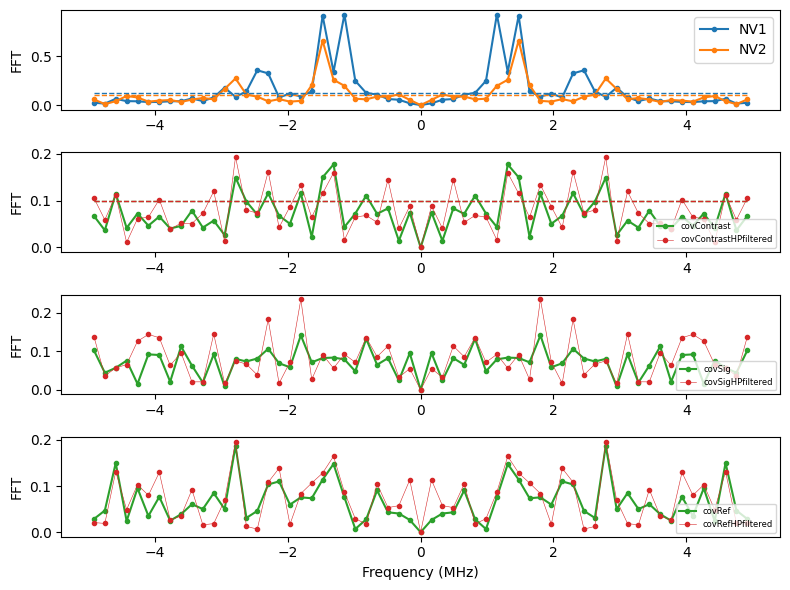

In [414]:
f, yfourier =  fourier(y,  delta_t=delta_t, f_factor=factor)
f2,yfourier2 = fourier(y2, delta_t=delta_t, f_factor=factor)
f3,yfourier3 = fourier(y3, delta_t=delta_t, f_factor=factor)
f4,yfourier4 = fourier(y4, delta_t=delta_t, f_factor=factor)
f, yfourier5 = fourier(y5, delta_t=delta_t, f_factor=factor)
f, yfourier6 = fourier(y6, delta_t=delta_t, f_factor=factor)
f, yfourier7 = fourier(y7, delta_t=delta_t, f_factor=factor)
f, yfourier8 = fourier(y8, delta_t=delta_t, f_factor=factor)

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(4,1, figsize=(8,6))

axs[0].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C0', label='NV1')
# axs[0].set_title('')
axs[0].set_ylabel('FFT')
# axs[0].legend()
# axs[1].set_ylim((0,10))

axs[0].plot(f2, yfourier2, linestyle='-', marker='o', markersize=3, color='C1', label='NV2')
# axs[1].set_title('')
axs[0].set_ylabel('FFT')
axs[0].legend()
# axs[1].set_ylim((0,1))

axs[1].plot(f3, yfourier3, linestyle='-', marker='o', markersize=3, color='C2', label='covContrast')
axs[1].plot(f4, yfourier4, linestyle='-', marker='o', markersize=3, color='C3', label='covContrastHPfiltered',linewidth=0.4)
axs[1].set_ylabel('FFT')
axs[1].legend(fontsize=6, loc='lower right')

axs[2].plot(f, yfourier5, linestyle='-', marker='o', markersize=3, color='C2', label='covSig')
axs[2].plot(f, yfourier6, linestyle='-', marker='o', markersize=3, color='C3', label='covSigHPfiltered',linewidth=0.4)
axs[2].set_ylabel('FFT')
axs[2].legend(fontsize=6, loc='lower right')

axs[3].plot(f, yfourier7, linestyle='-', marker='o', markersize=3, color='C2', label='covRef')
axs[3].plot(f, yfourier8, linestyle='-', marker='o', markersize=3, color='C3', label='covRefHPfiltered',linewidth=0.4)
axs[3].set_ylabel('FFT')
axs[3].legend(fontsize=6, loc='lower right')
axs[3].set_xlabel('Frequency (MHz)')

peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print('Peaks (kHz)', np.round(fpeaks2*1e3,1))

peaks3 = find_peaks(yfourier3, threshold=threshold3)
fpeaks3 = f[peaks3]; fpeaks3 = fpeaks3[int(len(fpeaks3)/2):]
print('Peaks (kHz)', np.round(fpeaks3*1e3,1))

peaks4 = find_peaks(yfourier4, threshold=threshold4)
fpeaks4 = f[peaks4]; fpeaks4 = fpeaks4[int(len(fpeaks4)/2):]
print('Peaks (kHz)', np.round(fpeaks4*1e3,1))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[0].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1, color='C1')
axs[1].hlines(y=threshold3, xmin=min(f3), xmax=max(f3), linestyle='--', linewidth = 1, color='C2')
axs[1].hlines(y=threshold4, xmin=min(f4), xmax=max(f4), linestyle='--', linewidth = 1, color='C3')

plt.tight_layout()
plt.show()

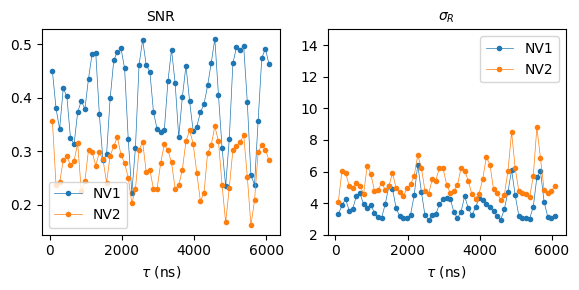

In [415]:
fig, axs = plt.subplots(1,2,figsize=(6,3))

axs[0].plot(taus, np.abs(snr_styleA), 'o-', linewidth=0.5, markersize=3, label="NV1")
axs[0].plot(taus, np.abs(snr_styleA2), 'o-', linewidth=0.5, markersize=3, label="NV2")
s = "SNR"
axs[0].set_title(s, fontsize=10)
# axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('$\\tau$ (ns)')

axs[1].plot(taus, np.abs(sigmaR_styleA),  'o-', linewidth=0.5, markersize=3, label="NV1")
axs[1].plot(taus, np.abs(sigmaR_styleA2), 'o-', linewidth=0.5, markersize=3, label="NV2")
s = "$\sigma_R$"
axs[1].set_title(s, fontsize=10)
# axs[1].set_xscale('log'); axs[1].set_yscale('log')
axs[1].set_ylim((2,15))
axs[1].legend()
axs[1].set_xlabel('$\\tau$ (ns)')

plt.tight_layout()
plt.show()

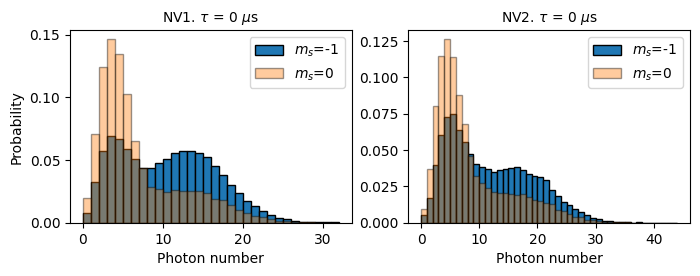

In [418]:
i=0
fig,axs = plt.subplots(1,2,figsize=(8,2.5))

hist, bins = np.histogram(sigs[i],bins=np.arange(np.max(sigs[i])+1))
axs[0].hist(sigs[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[0].hist(refs[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[0].set_yscale('log')
axs[0].legend()
s = r"NV1. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
axs[0].set_title(s, fontsize=10)
axs[0].set_ylabel('Probability')
axs[0].set_xlabel('Photon number')

hist, bins = np.histogram(sigs2[i],bins=np.arange(np.max(sigs2[i])+1))
axs[1].hist(sigs2[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[1].hist(refs2[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[1].set_yscale('log')
axs[1].legend()
s = r"NV2. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
axs[1].set_title(s, fontsize=10)
axs[1].set_xlabel('Photon number')

plt.show()

In [362]:
# filename = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\anticorrel_cov_con2_flip2.npy'
# np.savetxt(filename, covContrast, delimiter=',')
# filename = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\anticorrel_cov_sig2_flip2.npy'
# np.savetxt(filename, covSig, delimiter=',')
# filename = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\anticorrel_cov_ref2_flip2.npy'
# np.savetxt(filename, covRef, delimiter=',')

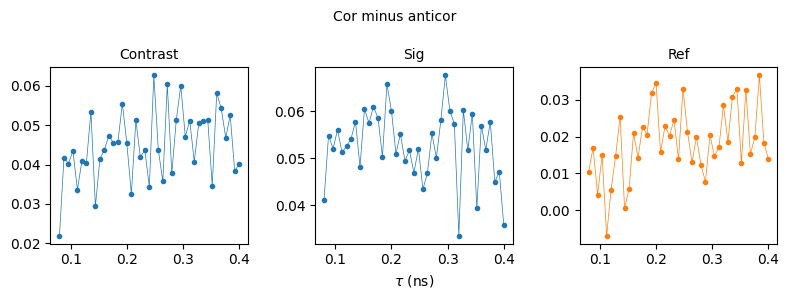

In [363]:
filename1 = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\correl_cov_con2.npy'
filename2 = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\anticorrel_cov_con2_flip2.npy'
cor = np.loadtxt(filename1, delimiter=',')
anticor = np.loadtxt(filename2, delimiter=',')
corMinusAnticorCon = cor-anticor

filename1 = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\correl_cov_sig2.npy'
filename2 = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\anticorrel_cov_sig2_flip2.npy'
cor = np.loadtxt(filename1, delimiter=',')
anticor = np.loadtxt(filename2, delimiter=',')
corMinusAnticorSig = cor-anticor

filename1 = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\correl_cov_ref2.npy'
filename2 = 'C:\\Users\\lukin2dmaterials\\data\\2024-01-05\\anticorrel_cov_ref2_flip2.npy'
cor = np.loadtxt(filename1, delimiter=',')
anticor = np.loadtxt(filename2, delimiter=',')
corMinusAnticorRef = cor-anticor

fig, axs = plt.subplots(1,3,figsize=(8,3)); fontsize=10

axs[0].plot(x, corMinusAnticorCon, 'o-', linewidth=0.5, markersize=3, label="covRef")
s = "Contrast"
axs[0].set_title(s, fontsize=fontsize)
# axs[0].set_xlim((0,0.6))

axs[1].plot(x, corMinusAnticorSig, 'o-', linewidth=0.5, markersize=3, label="covSig")
s = "Sig"
axs[1].set_title(s, fontsize=fontsize)
axs[1].set_xlabel('$\\tau$ (ns)')

axs[2].plot(x, corMinusAnticorRef, 'o-', linewidth=0.5, markersize=3, label="covRef", color='C1')
s = "Ref"
axs[2].set_title(s, fontsize=fontsize)
fig.suptitle('Cor minus anticor', fontsize=fontsize)

plt.tight_layout()

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16204\158459157.py:6: RuntimeWarning: invalid value encountered in log
  sens = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+tr))))
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16204\158459157.py:16: RuntimeWarning: invalid value encountered in log
  sens2 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * 35**2 * np.exp(2*t/T2) / np.sqrt(T/(t+300e-9))))
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16204\158459157.py:20: RuntimeWarning: invalid value encountered in log
  sens3 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+ti+tr))))
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16204\158459157.py:24: RuntimeWarning: invalid value encountered in log
  sens4 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+ti+tr))))
C:\Users\lukin2dmaterials\AppData\L

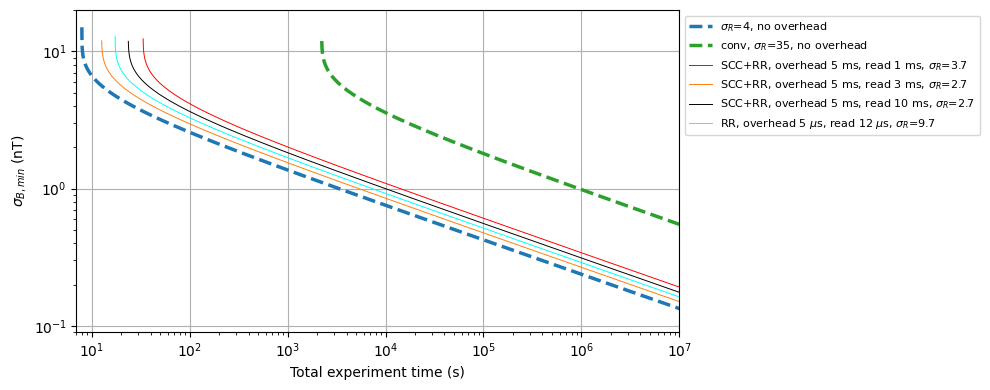

In [2814]:
T = np.logspace(0,9,10000)
gamma = 2*pi*28.025*1e9
sigma = 4
T2 = 100e-6; t = T2/2
tr = 1e-3; Hz = 2*pi
sens = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+tr))))

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(T,sens, linewidth=2.5, linestyle='--',label='$\sigma_R$=4, no overhead')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim((7,1e7))
ax.set_ylim((0.09,20))
ax.grid(True)

sens2 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * 35**2 * np.exp(2*t/T2) / np.sqrt(T/(t+300e-9))))
ax.plot(T,sens2, linewidth=2.5, linestyle='--', color='C2', label='conv, $\sigma_R$=35, no overhead')

ti = 5e-3; tr=1e-3; sigma=3.7
sens3 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+ti+tr))))
ax.plot(T,sens3,linewidth=0.7, color='red', label='SCC+RR, overhead 5 ms, read 1 ms, $\sigma_R$=3.7')

ti = 5e-3; tr=3e-3; sigma=2.7
sens4 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+ti+tr))))
ax.plot(T,sens4,linewidth=0.7, label='SCC+RR, overhead 5 ms, read 3 ms, $\sigma_R$=2.7')

ti = 5e-3; tr=10e-3; sigma=2.7
sens5 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+ti+tr))))
ax.plot(T,sens5,linewidth=0.7, color='k', label='SCC+RR, overhead 5 ms, read 10 ms, $\sigma_R$=2.7')

ti = 5e-6; tr=12e-6; s1 = 4/(1e3/12); s2 = 1/(1e3/12); snr = (s1-s2)/np.sqrt(s1+s2); sigma=np.sqrt(1 + 2/snr**2)
sens6 = Hz*1e9*np.sqrt(-pi/(4 * gamma**2 * t) * np.log(1 - 2 * sigma**2 * np.exp(2*t/T2) / np.sqrt(T/(t+ti+tr))))
ax.plot(T,sens6,linewidth=0.7, color='cyan', label='RR, overhead 5 $\mu$s, read 12 $\mu$s, $\sigma_R$=%.1f' % sigma)

ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Total experiment time (s)')
ax.set_ylabel('$\sigma_{B,min}$ (nT)')

# ys = np.logspace(-0.7,1,300); ratios = []
# for y in ys:
#     closest_index = np.abs(sens - y).argmin()
#     x1 = T[closest_index]
#     closest_index = np.abs(sens2 - y).argmin()
#     x2 = T[closest_index]
#     ratios.append(x2/x1)
# np.array(ratios)
# ax2 = ax.twiny()
# ax2.plot(ratios,ys)

plt.tight_layout()

In [1145]:
sigma

1.0066445913694333

In [492]:
2 * 35**2 * np.exp(2*t/T2) / np.sqrt(10/(t+300e-9))

14.936352648694763

### Repeat measuring XY8

In [ ]:
days = np.linspace(10,10,1)
sigs = None; refs = None; sigs2 = None; refs2 = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'XY8SCCRRIrberDualNV' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 98 and idx <= 703 and np.mod(idx,1) == 0:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/XY8SCCRRIrberDualNVObject_sig_set.dat'
                ti = 2500; tr_ns = 1e6

                # taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                sigavg = np.average(sig,axis=1); refavg = np.average(ref,axis=1)
                sigavg2 = np.average(sig2,axis=1); refavg2 = np.average(ref2,axis=1)

                ################################################
                x = taus/1e3
                y = (sigavg-refavg)/(sigavg+refavg); y2 = (sigavg2-refavg2)/(sigavg2+refavg2)

                fig, axs = plt.subplots(2,2, figsize=(6,5))
                fig.suptitle('231223 DS ' + str(idx), fontsize=10)
                a00 = axs[0,0]; a10 = axs[1,0]; a01 = axs[0,1]; a11 = axs[1,1]

                a00.plot(x,y, 'o-', linewidth=0.5, markersize=3, label="$C_{tot}$", color='C0')
                a00.set_ylabel("Contrast")
                a00.legend(fontsize=7, loc='lower left')
                a00.set_title('NV1 DS' + str(idx), fontsize=10)

                a10.plot(x, sigavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="$m_s$=-1")
                a10.plot(x, refavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="$m_s$=0")
                a10.legend(fontsize=6)
                a10.set_ylabel('Count (kc/s)')
                a10.set_xlabel("$\\tau$ ($\mu$s)")

                a01.plot(x,y2, 'o-', linewidth=0.5, markersize=3, label="$C_{tot}$", color='C0')
                a01.legend(fontsize=7, loc='lower left')
                a01.set_title('NV2', fontsize=10)

                a11.plot(x, sigavg2/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="$m_s$=-1")
                a11.plot(x, refavg2/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="$m_s$=0")
                a11.legend(fontsize=6)
                a11.set_xlabel("$\\tau$ ($\mu$s)")


                plt.tight_layout()
                plt.show()
                

# T2E/XY8 SCC RR Single read

In [ ]:
for file in os.listdir('C:/Users/lukin2dmaterials/miniconda3/envs/NV_control/B00_codes'):
    if 'T1' in file:
        print(file)

In [386]:
# Repeat measuring T2E/XY8
days = np.linspace(9,26,18)
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNVSingleRead'; name2 = '/T2ESCCRRIrberDualNVSingleReadObject_sig_set.dat'
elif type == 'XY8':
    name1 = 'XY8SCCRRIrberDualNVSingleRead'; name2 = '/XY8SCCRRIrberDualNVSingleReadObject_sig_set.dat'
else:
    name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if name1 in dataFolder:
            idx = int(dataFolder[1:4])
            # if (day == 9 and idx >= 104) or day== 10 or (day==11 and idx<=65):
            # if day == 12 and (idx <= 27 or idx >= 89) or (day==13 and idx<=1):
            # if day == 12 and idx >= 75 and idx <= 84:
            # if day == 13 and idx <= 82:
            # if (day == 12 and (idx <= 27 or idx >= 89)) or (day == 13 and idx<=82) or (day == 14 and  idx <= 22):
            # if (day==16 and idx >=7 and idx <=41):
            # if (day == 16 and idx >= 111) or (day== 17) or (day==18 and idx <= 14):
            if (day == 18 and idx >= 16) or (day == 19 and idx <= 13):
            # if day == 19 and idx >= 16 and idx <= 31:
            # if (day == 19 and idx >= 36 and idx <= 39) or (day == 16 and idx <= 41 and idx >=7):
            # if (day == 19 and idx >= 43 and idx <= 44) or (day == 20 and idx >= -30 and idx <= 36):
            # if (day == 21 and idx >= 37) or day==22 or (day == 23 and idx <=15):
            # if (day == 23 and idx >= 16) or (day == 24 and idx <= 25):
            # if (day == 24 and idx >= 27) or (day == 25) or (day==26 and idx <= 14):
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder + name2
                ti = 2700; tr_ns = 3e6

                taus, sig, ref = dr.readDataFullDataDualNVSingleRead(datafile)

                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if refs is None: refs = ref
                else: refs = np.concatenate((refs, ref),axis=1)
                
print(np.shape(sigs))         

(93, 52000)


In [387]:
thres = 12; ifSketchyNorm=0
# sigs = thresholded(sigs,thres); refs = thresholded(refs,thres)

sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)

sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)

snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

# contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5

contrast = contrast_new(sigs,refs,sigavg,refavg)
contrast_avg = np.average(contrast, axis=1)
a0 = 2.2; a1=1.4; b0= 6; b1=2.9
corr = 0*1/4*((tr_ns/1e6*(a0-a1))**2 + (tr_ns/1e6*(b0-b1))**2)
coeff = 0
covSig = np.var(sigs,axis=1)-coeff*np.mean(sigs,axis=1)-corr
covRef = np.var(refs,axis=1)-coeff*np.mean(refs,axis=1)-corr
# covContrast = np.var(contrast,axis=1)  
covContrast = -(covSig - covRef)
r = covContrast/(covSig + covRef)
y = (sigavg-refavg)/(sigavg+refavg)

# y = linear_map(y,-(y.max()),y.max(),0,1)
y = 1/0.6*y + 0.5 # norm to contrast in cosine detection SCC RR

if ifSketchyNorm != 0:
    y = (y-y.min())/(y.max()-y.min())
    z = covContrast; covContrast = (z-z.min())/(z.max()-z.min())
    # covContrast = covContrast*2-1
    covContrast = ifSketchyNorm*(covContrast-y)

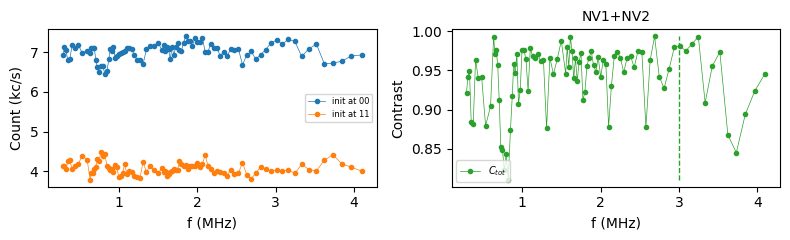

In [389]:
ifXAxisFreq=1; correctionToTau = 42; markerAt = 3; color='C2'
###### Check the legend before saving image ##########################################
x = (taus+correctionToTau)/1e3; t = x
if ifXAxisFreq: x = 1/(2*(taus+correctionToTau)*1e-3)

fig, axs = plt.subplots(1,2, figsize=(8,2.5))
a00 = axs[1]; a01 = axs[0]

a00.plot(x,y, 'o-', linewidth=0.5, markersize=3, label="$C_{tot}$", color=color)
a00.set_ylabel("Contrast")
a00.legend(fontsize=7, loc='lower left')
a00.set_title('NV1+NV2', fontsize=10)
a00.set_xlabel("$\\tau$ ($\mu$s)")
if ifXAxisFreq: 
    a00.set_xlabel("f (MHz)")
else:
    markerAt = 1/(2*markerAt)
a00.vlines(x=markerAt,ymin=min(y),ymax=max(y), color=color,linestyle='--',linewidth=1)

a01.plot(x, sigavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="init at 00")
a01.plot(x, refavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="init at 11")
a01.legend(fontsize=6)
a01.set_ylabel('Count (kc/s)')
a01.set_xlabel("$\\tau$ ($\mu$s)")
if ifXAxisFreq: a01.set_xlabel("f (MHz)")
# a00.set_xlim((0,0.5))
# a00.set_xscale('log')

plt.tight_layout()
plt.show()

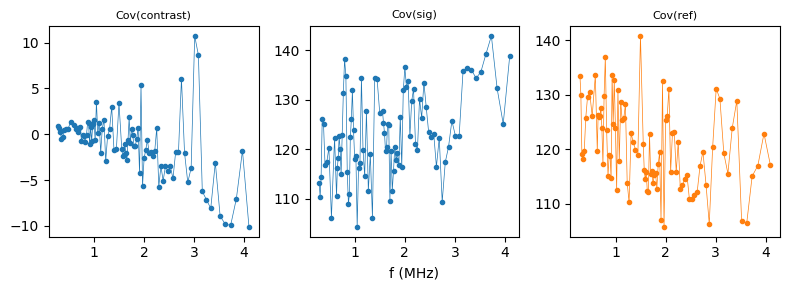

In [3200]:
fig, axs = plt.subplots(1,3,figsize=(8,3))

# sf = np.arcsinh(10*r/(c1_OldRR_XY85*c2_OldRR_XY852))/t
# ycov_OldRR_XY85 = -sf

sf = np.arcsinh(10*r/(c1t*c2t))/t
ycov = sf
axs[0].plot(x, ycov, 'o-', linewidth=0.5, markersize=3, label="covRef")
s = "Cov(contrast)"
axs[0].set_title(s, fontsize=8)

axs[1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="covSig")
s = "Cov(sig)"
axs[1].set_title(s, fontsize=8)
axs[1].set_xlabel('$\\tau$ ($\mu$s)')

axs[2].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="covRef", color='C1')
s = "Cov(ref)"
axs[2].set_title(s, fontsize=8)

if ifXAxisFreq: 
    axs[1].set_xlabel("f (MHz)")
    # for i in range(3):
    #     axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

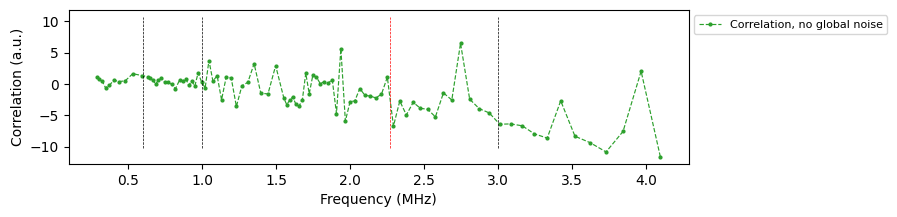

In [3008]:
fig,ax = plt.subplots(figsize=(8,2))
factor = 1
ax.plot(x,ycov_OldRR_XY85*factor,linestyle='--', marker='o', linewidth=0.85,markersize=2,color='C2', label='Correlation, no global noise')
# ax.plot(x,ycov,linestyle='--', marker='o', linewidth=0.85,markersize=2,color='C3', label='Correlation, with global noise')
ax.legend(fontsize=8,loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('$S_{Corr}$ (f) (a.u.)')

minval = min(ycov); maxval = max(ycov)
ax.vlines(x=3, ymin=minval , ymax=maxval, linestyle='--',linewidth=0.5, color='black')
ax.vlines(x=1, ymin=minval , ymax=maxval, linestyle='--',linewidth=0.5, color='black')
ax.vlines(x=0.6, ymin=minval , ymax=maxval, linestyle='--',linewidth=0.5, color='black')

# ax.vlines(x=1.94, ymin=min(ycov), ymax=max(ycov), linestyle='--',linewidth=0.5, color='red')
ax.vlines(x=2.27, ymin=min(ycov), ymax=max(ycov), linestyle='--',linewidth=0.5, color='red')

In [2283]:
cOld = covContrast
xOld = x

In [ ]:
fig,ax = plt.subplots(figsize=(8,2))
ax.plot(xOld,cOld,linestyle='--', marker='o', linewidth=0.85,markersize=2,color='C2', label='Correlation, no global noise')
# ax.plot(xNew,cNew,linestyle='--', marker='o', linewidth=0.85,markersize=2,color='C3', label='Correlation, with global noise')
ax.legend(fontsize=8)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Correlation (a.u.)')

In [2395]:
navg=5

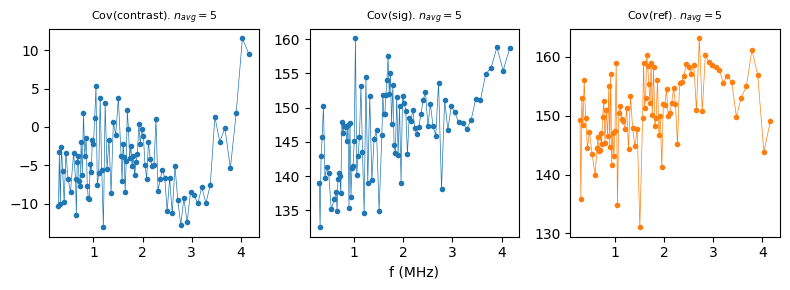

In [2396]:
sigsNew = np.zeros(np.shape(sigs)); refsNew = np.zeros(np.shape(sigs))

for i in range(len(sig)):
    # sigsNew[i] = subtractMeanFewReps(sigs[i],navg)
    # refsNew[i] = subtractMeanFewReps(refs[i],navg)

    # sigsNew[i] = smoothConvolution(sigs[i],navg)
    # refsNew[i] = smoothConvolution(refs[i],navg)

    sigsNew[i] = sigs[i]-smoothConvolution(sigs[i],navg)
    refsNew[i] = refs[i]-smoothConvolution(refs[i],navg)

covSigNew = np.var(sigsNew,axis=1); covRefNew = np.var(refsNew,axis=1)
contrastNew = contrast_new(sigsNew,refsNew,sigavg,refavg)
# covContrastNew = np.var(contrastNew,axis=1)  
covContrastNew = covSigNew - covRefNew
############################################################

fig, axs = plt.subplots(1,3,figsize=(8,3))

axs[0].plot(x, covContrastNew, 'o-', linewidth=0.5, markersize=3, label="covRef")
s = "Cov(contrast). $n_{avg}=%.0f$" % navg
axs[0].set_title(s, fontsize=8)

axs[1].plot(x, covSigNew, 'o-', linewidth=0.5, markersize=3, label="covSig")
s = "Cov(sig). $n_{avg}=%.0f$" % navg
axs[1].set_title(s, fontsize=8)
if ifXAxisFreq: axs[1].set_xlabel("f (MHz)")

axs[2].plot(x, covRefNew, 'o-', linewidth=0.5, markersize=3, label="covRef", color='C1')
s = "Cov(ref). $n_{avg}=%.0f$" % navg
axs[2].set_title(s, fontsize=8)

if ifXAxisFreq: 
    axs[1].set_xlabel("f (MHz)")
    # for i in range(3):
    #     axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

In [223]:
y3 = covContrast; y4=covContrastNew; 
y5 = covSig; y6=covSigNew; 
y7 = covRef; y8=covRefNew; 
delta_t=100e-9; factor=1e6; threshold = .1; threshold5=3; threshold7=3; threshold3 = 3; 
fontsize=8; ifPlotHPFiltered=1

In [ ]:
f, yfourier =  fourier(y,  delta_t=delta_t, f_factor=factor)
f3,yfourier3 = fourier(y3, delta_t=delta_t, f_factor=factor)
f4,yfourier4 = fourier(y4, delta_t=delta_t, f_factor=factor)
f, yfourier5 = fourier(y5, delta_t=delta_t, f_factor=factor)
f, yfourier6 = fourier(y6, delta_t=delta_t, f_factor=factor)
f, yfourier7 = fourier(y7, delta_t=delta_t, f_factor=factor)
f, yfourier8 = fourier(y8, delta_t=delta_t, f_factor=factor)

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(4,1, figsize=(8,6))

axs[0].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C0', label='NV1+NV2, averaged')
axs[0].set_ylabel('FFT')
axs[0].legend(fontsize=fontsize)
# axs[1].set_ylim((0,10))

axs[3].plot(f3, yfourier3, linestyle='-', marker='o', markersize=3, color='C1', label='Contrast')
axs[3].set_ylabel('FFT')
axs[3].legend(fontsize=fontsize, loc='upper right')

axs[1].plot(f, yfourier5, linestyle='-', marker='o', markersize=3, color='C2', label='Correlation, both init to 0')
axs[1].set_ylabel('FFT')
axs[1].legend(fontsize=fontsize, loc='upper right')

axs[2].plot(f, yfourier7, linestyle='-', marker='o', markersize=3, color='C4', label='Anticorrelation, init to (0, -1)')
axs[2].set_ylabel('FFT')
axs[2].legend(fontsize=fontsize, loc='upper right')
axs[3].set_xlabel('Frequency (MHz)')

if ifPlotHPFiltered:
    axs[3].plot(f4, yfourier4, linestyle='-', marker='o', markersize=3, color='C3', label='covContrastHPfiltered',linewidth=0.4)
    axs[1].plot(f, yfourier6, linestyle='-', marker='o', markersize=3, color='C3', label='covSigHPfiltered',linewidth=0.4)
    axs[2].plot(f, yfourier8, linestyle='-', marker='o', markersize=3, color='C3', label='covRefHPfiltered',linewidth=0.4)

peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

peaks5 = find_peaks(yfourier5, threshold=threshold5)
fpeaks5 = f[peaks5]; fpeaks5 = fpeaks5[int(len(fpeaks5)/2):]
print('Peaks (kHz)', np.round(fpeaks5*1e3,1))

peaks7 = find_peaks(yfourier7, threshold=threshold7)
fpeaks7 = f[peaks7]; fpeaks7 = fpeaks7[int(len(fpeaks7)/2):]
print('Peaks (kHz)', np.round(fpeaks7*1e3,1))

peaks3 = find_peaks(yfourier3, threshold=threshold3)
fpeaks3 = f[peaks3]; fpeaks3 = fpeaks3[int(len(fpeaks3)/2):]
print('Peaks (kHz)', np.round(fpeaks3*1e3,1))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[3].hlines(y=threshold3, xmin=min(f3), xmax=max(f3), linestyle='--', linewidth = 1, color='C1')
axs[1].hlines(y=threshold5, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1, color='C2')
axs[2].hlines(y=threshold7, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1, color='C4')

for i in ((-1,-0.5,0.5,1)):
    axs[0].vlines(x=-3.125*i, ymin=min(yfourier),  ymax=max(yfourier),  linestyle='--', linewidth = 1)
    axs[3].vlines(x=-3.1343*i, ymin=min(yfourier3), ymax=max(yfourier3), linestyle='--', linewidth = 1, color='C1')
    axs[1].vlines(x=-3.1343*i, ymin=min(yfourier5), ymax=max(yfourier5), linestyle='--', linewidth = 1, color='C2')
    axs[2].vlines(x=-3.1343*i, ymin=min(yfourier7), ymax=max(yfourier7), linestyle='--', linewidth = 1, color='C4')

for i in range(4):
    axs[i].set_xlim((-0.1, max(f)*1.02))
plt.tight_layout()
plt.show()

In [ ]:
np.round(1/(2*np.linspace(2e6,4.5e6,101))*1e9,0)

# Repeat T2E/XY8 SCC RR Single read

In [2972]:
days = np.linspace(25,25,1); type='XY8'
start_idx = 32; end_idx = 1117

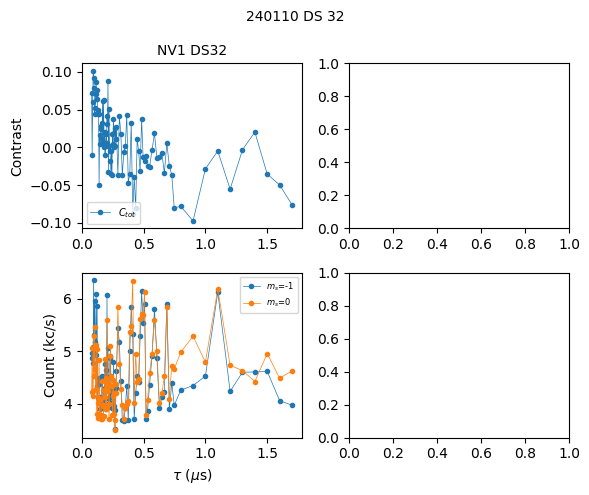

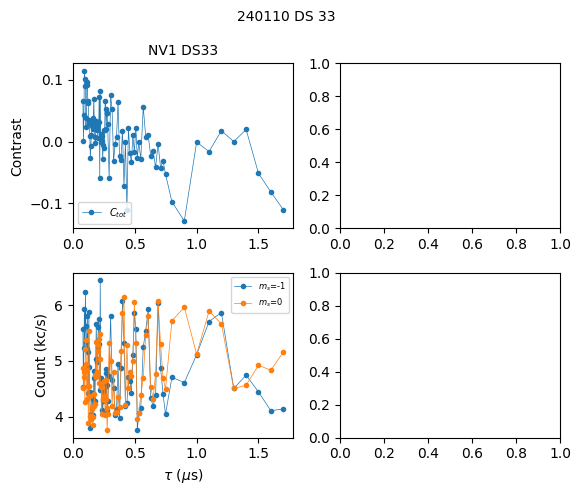

In [2973]:
sigs = None; refs = None
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNVSingleRead'; name2 = '/T2ESCCRRIrberDualNVSingleReadObject_sig_set.dat'
elif type == 'XY8':
    name1 = 'XY8SCCRRIrberDualNVSingleRead'; name2 = '/XY8SCCRRIrberDualNVSingleReadObject_sig_set.dat'
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if name1 in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= start_idx and idx <= end_idx and np.mod(idx,1) == 0:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder + name2
                ti = 2500; tr_ns = 3e6

                # taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                taus, sig, ref = dr.readDataFullDataDualNVSingleRead(datafile)

                # Sort data taken in random order
                taus = np.average(taus,axis=1)
                sorted_indices = np.argsort(taus)
                taus = taus[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                sigavg = np.average(sig,axis=1); refavg = np.average(ref,axis=1)
              
                ################################################
                x = taus/1e3
                y = (sigavg-refavg)/(sigavg+refavg)

                fig, axs = plt.subplots(2,2, figsize=(6,5))
                fig.suptitle('240110 DS ' + str(idx), fontsize=10)
                a00 = axs[0,0]; a10 = axs[1,0]; a01 = axs[0,1]; a11 = axs[1,1]

                a00.plot(x,y, 'o-', linewidth=0.5, markersize=3, label="$C_{tot}$", color='C0')
                a00.set_ylabel("Contrast")
                a00.legend(fontsize=7, loc='lower left')
                a00.set_title('NV1 DS' + str(idx), fontsize=10)

                a10.plot(x, sigavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="$m_s$=-1")
                a10.plot(x, refavg/(tr_ns/1e6), 'o-', linewidth=0.5, markersize=3, label="$m_s$=0")
                a10.legend(fontsize=6)
                a10.set_ylabel('Count (kc/s)')
                a10.set_xlabel("$\\tau$ ($\mu$s)")

                plt.tight_layout()
                plt.show()
                

In [ ]:
for i in np.linspace(2,20,10):
    fig, ax = plt.subplots(figsize=(4,3))
    shifted = np.roll(sigs,int(i))
    ax.plot(x,cov(sigs,shifted), 'o-', linewidth=0.5, markersize=3, )
    ax.plot(x,cov(sigs,refs), 'o-', linewidth=0.5, markersize=3, )

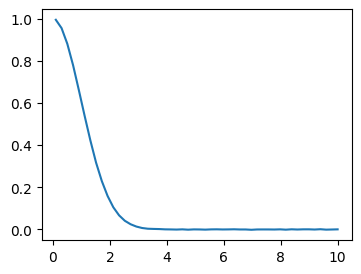

In [670]:
std_devs = np.linspace(0.1,10,50)
mean = 0; y = []
for std_dev in std_devs:
    data = np.random.normal(mean, std_dev, 1000000)
    datacos = np.cos(data)
    y.append(np.average(datacos))# - np.exp(-np.var(data)/2))
y = np.array(y)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(std_devs,y)

# Confocal RR

In [457]:
# Repeat measuring T2E
days = np.linspace(28,28,1)
sigs = None; sigs2 = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'ConfocalRR' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx == 110:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/ConfocalRRObject_y_set_ConfocalRRObject_sig2_set.dat'

                x,y,sig2,sig = dr.readDataConfocalRR(datafile)

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if sigs2 is None: sigs2 = sig2
                else: sigs2 = np.concatenate((sigs2, sig2),axis=1)

print(np.shape(sigs))


(13, 18)


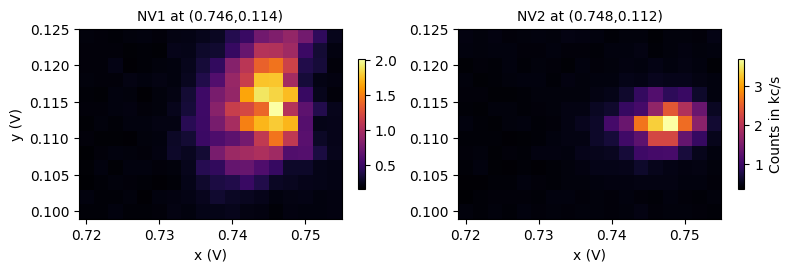

In [458]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
fontsize=10
plot0 = axs[0].pcolormesh(x,y,sig, cmap='inferno')
cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0],shrink=0.5)
axs[0].set_xlabel('x (V)')
axs[0].set_ylabel('y (V)')
axs[0].set_aspect('equal')
idx = np.unravel_index(np.argmax(sig), sig.shape)
axs[0].set_title('NV1 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)

ifAddSig = 0
plot1 = axs[1].pcolormesh(x,y,sig2+ifAddSig*sig, cmap='inferno')
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1],shrink=0.5)
cb1.set_label("Counts in kc/s",fontsize=fontsize)
axs[1].set_xlabel('x (V)')
axs[1].set_aspect('equal')
idx = np.unravel_index(np.argmax(sig2+ifAddSig*sig), sig2.shape)
axs[1].set_title('NV2 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)

plt.tight_layout()

In [465]:
m,n = np.shape(sig); fontsize=8
calib = 32; wvl = 637; xs = []; ys = []

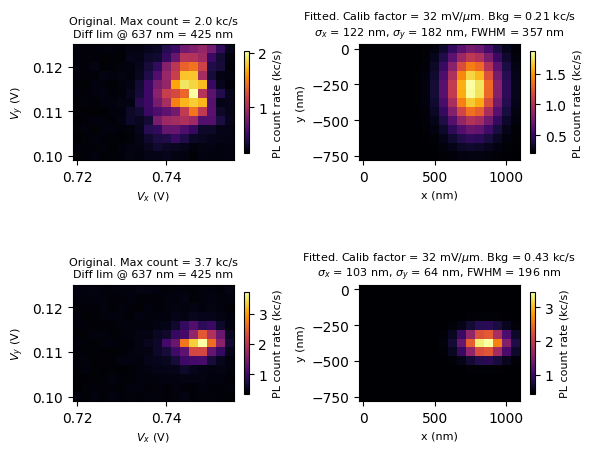

86.4607111880876 97.90497233949343 130.61714354535115


In [466]:
fig, ax = plt.subplots(2, 2,  figsize=(6,5))
for i in range(2):
    if i==0: data = sig
    else: data = sig2
    z = data.ravel()

    # Initial guesses for the parameters (amplitude, x0, y0, sigma_x, sigma_y, offset)
    initial_guess = [25, 0.746, 0.114, 0.01, 0.01, 1]

    # Fit the 2D Gaussian to the data
    fit_params, _ = curve_fit(gaussian_2d, (x, y), z, p0=initial_guess)

    # Extract the fitted parameters
    amplitude_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit, offset_fit = fit_params
    xs.append(x0_fit); ys.append(y0_fit)

    # Evaluate the fitted Gaussian function at all (x, y) points
    fitted_data = gaussian_2d((x, y), *fit_params)
    fitted_data = fitted_data.reshape(m,n)

    # Plot the original data and the fitted Gaussian
    plot0 = ax[i,0].pcolormesh(x,y, data, cmap='inferno')
    s1 = 'Original. Max count = %.1f kc/s' % (np.max(data))
    s2 = 'Diff lim @ %.0f nm = %.0f nm' % (wvl, wvl/2/0.75)
    ax[i,0].set_title(s1 + "\n" +s2, fontsize=fontsize)
    ax[i,0].set_xlabel('$V_x$ (V)',fontsize=fontsize)
    ax[i,0].set_ylabel('$V_y$ (V)',fontsize=fontsize)
    ax[i,0].set_aspect('equal')

    xnm = (x-x[0][0])*1e3/calib*1e3; ynm = (y-y[0][0])*1e3/calib*1e3
    plot1 = ax[i,1].pcolormesh(xnm, ynm, fitted_data, cmap='inferno')
    sx =  np.abs(fit_params[3]*1e3/calib*1e3); sy = np.abs(fit_params[4]*1e3/calib*1e3)
    s1 = "Fitted. Calib factor = %.0f mV/$\mu$m. Bkg = %.2f kc/s" % (calib, fit_params[5])
    s2 = "$\sigma_x$ = %.0f nm, $\sigma_y$ = %.0f nm, FWHM = %.0f nm" % (sx, sy, (sx+sy)/2*2.355)
    ax[i,1].set_title(s1 + "\n" + s2, fontsize=fontsize)
    ax[i,1].set_xlabel('x (nm)',fontsize=fontsize)
    ax[i,1].set_ylabel('y (nm)',fontsize=fontsize)
    ax[i,1].set_aspect('equal')

    cb0 = fig.colorbar(plot0, orientation='vertical', ax=ax[i,0],shrink=0.5)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=ax[i,1],shrink=0.5)
    cb0.set_label('PL count rate (kc/s)',fontsize=fontsize)
    cb1.set_label('PL count rate (kc/s)',fontsize=fontsize)

plt.tight_layout()
plt.show()

xs = np.array(xs); ys = np.array(ys)
delta_x = np.abs(xs[0]-xs[1])*1e3/calib*1e3
delta_y = np.abs(ys[0]-ys[1])*1e3/calib*1e3
dist = np.sqrt(delta_x**2 + delta_y**2)
print(delta_x, delta_y, dist)

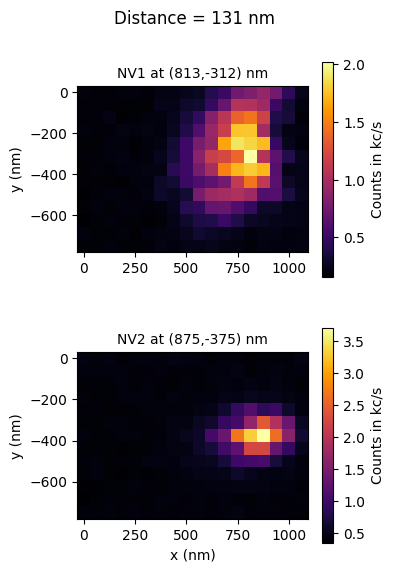

In [467]:
fig,axs = plt.subplots(2,1,figsize=(4,6))
fontsize=10
plot0 = axs[0].pcolormesh(xnm,ynm,sig, cmap='inferno')
cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0],shrink=.9)
cb0.set_label("Counts in kc/s",fontsize=fontsize)
axs[0].set_ylabel('y (nm)')
axs[0].set_aspect('equal')
idx = np.unravel_index(np.argmax(sig), sig.shape)
axs[0].set_title('NV1 at (%.0f,%.0f) nm' % (xnm[idx], ynm[idx]),fontsize=fontsize)

ifAddSig = 0
plot1 = axs[1].pcolormesh(xnm,ynm,sig2+ifAddSig*sig, cmap='inferno')
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1],shrink=.9)
cb1.set_label("Counts in kc/s",fontsize=fontsize)
axs[1].set_xlabel('x (nm)')
axs[1].set_ylabel('y (nm)')
axs[1].set_aspect('equal')
idx = np.unravel_index(np.argmax(sig2+ifAddSig*sig), sig2.shape)
axs[1].set_title('NV2 at (%.0f,%.0f) nm' % (xnm[idx], ynm[idx]),fontsize=fontsize)

fig.suptitle('Distance = %.0f nm' % dist)
plt.tight_layout()

In [54]:
# Repeat measuring CFC RR SR
days = np.linspace(10,10,1)
sigs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'ConfocalRRSingleRead' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx == 79:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/ConfocalRRSingleReadObject_y_set_ConfocalRRSingleReadObject_sig_set.dat'

                x,y,sig = dr.readDataConfocalRRSingleRead(datafile)

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
print(np.shape(sigs))


(16, 51)


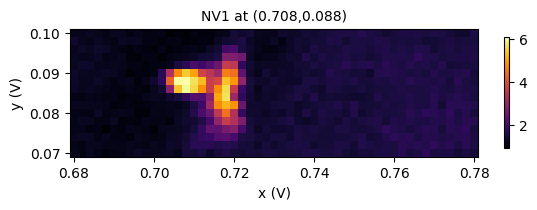

In [58]:
fig,ax = plt.subplots(figsize=(6,4))
fontsize=10
plot0 = ax.pcolormesh(x,y,sig, cmap='inferno')
cb0 = fig.colorbar(plot0, orientation='vertical', ax=ax,shrink=0.3)
ax.set_xlabel('x (V)')
ax.set_ylabel('y (V)')
ax.set_aspect('equal')
idx = np.unravel_index(np.argmax(sig), sig.shape)
ax.set_title('NV1 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)

plt.tight_layout()

In [404]:
tkFile = 'C:/Users/lukin2dmaterials/data/tk.txt'; lines = []
with open(tkFile, 'r') as file:
    for line in file:
        if "\n" in line: line = line[0:-1]
        lines.append(line)